(Planned)

Figure 1. Conceptual Diagram of an IMAS/IDS-based Integrated Workflow (CH 1)

Figure 2. Overall Architecture of the VEST Integrated Platform (CH 2)

Figure 3. VEST 2D Poloidal Geometry for Electromagnetic Modeling (CH 3)

INFO:vaft.omas.process_wrapper:Computing grid response (Psi)...
INFO:vaft.omas.process_wrapper:Processing 10 active coils...
INFO:vaft.omas.process_wrapper:Coil contributions complete.
INFO:vaft.omas.process_wrapper:Processing 950 passive loops...
INFO:vaft.omas.process_wrapper:Loop contributions complete.
INFO:vaft.omas.process_wrapper:Grid response computation complete.


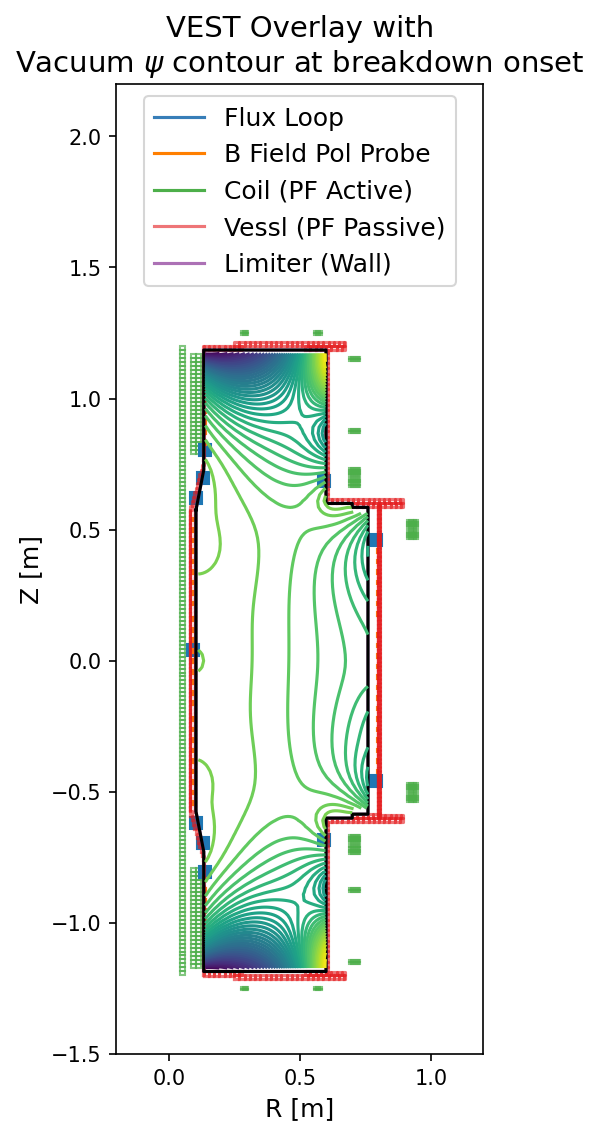

(<Figure size 600x1260 with 1 Axes>,
 <Axes: title={'center': 'VEST Overlay with\nVacuum $\\psi$ contour at breakdown onset'}, xlabel='R [m]', ylabel='Z [m]'>)

In [1]:
import vaft
ods = vaft.omas.sample_ods()
vaft.plot.overlay_all_with_vacuum_psi_contour(ods)

In [2]:
from omas import *
import vaft
import matplotlib.pyplot as plt


# matplotlib 설정 개선
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20


# ods = vaft.omas.sample_ods()
# vaft.plot.overlay_all_with_vacuum_psi_contour(ods)

PastedGraphic-1.png

Figure 4. Equilibrium Refinement using CHEASE

In [1]:
from omas import *
import vaft
import matplotlib.pyplot as plt
from omfit_classes.omfit_eqdsk import OMFITeqdsk

shot = 41606
time_ms = 329
time_s = time_ms / 1000.0
eq_chease = OMFITeqdsk(f'/srv/vest.filedb/public/{shot}/chease/g0{shot}.00{time_ms}')
ods_chease = eq_chease.to_omas()
ods_chease['equilibrium.time_slice.0.profiles_1d.j_tor'] = abs(ods_chease['equilibrium.time_slice.0.profiles_1d.j_tor'])
eq = OMFITeqdsk(f'/srv/vest.filedb/public/{shot}/efit/gfile/g0{shot}.00{time_ms}')
ods_efit = eq.to_omas()

Flux surfaces from 513x513 gEQDSK
Levels based on psi ...
Grid diagonal resolution: 0.002332198415083543 [m]
Cropping tables ...
Find magnetic axis ...
Tracing flux surfaces ...
  > Took 0:00:06.098426
Find Br, Bz, F on flux surfaces ...
  > Took 0:00:00.491639
Flux surface averaging ...
  > Took 0:00:00.586864
Geometric quantities ...
  > Took 0:00:01.295566


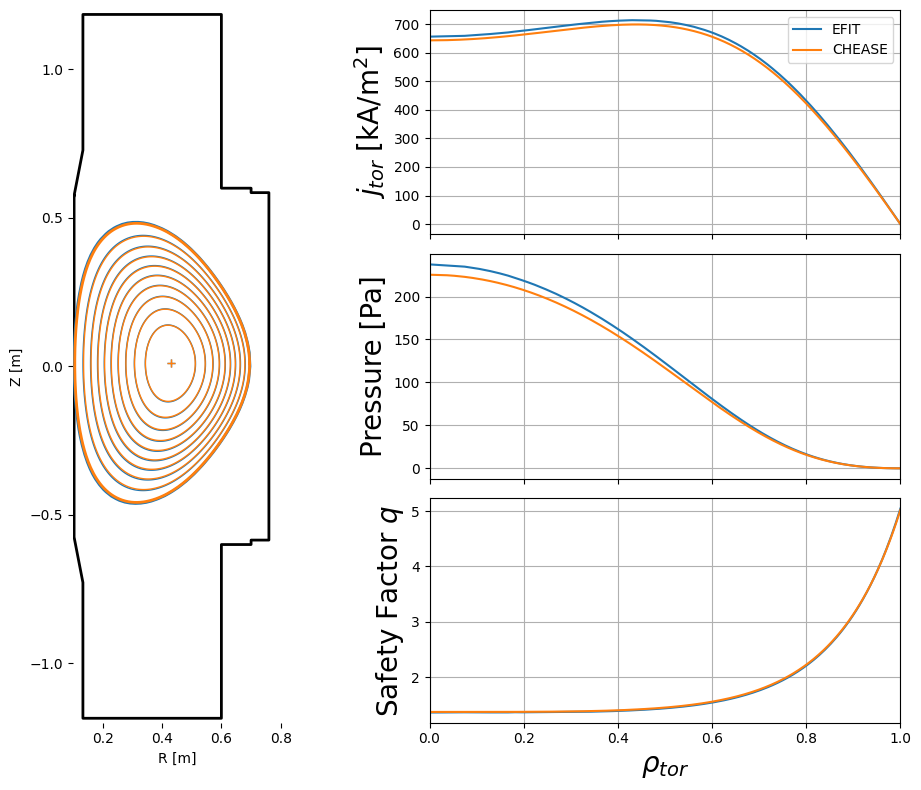

In [6]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from omas import *
from omfit_classes.omfit_eqdsk import OMFITeqdsk
import copy
import numpy as np
from matplotlib import pyplot as plt, patches, path
from omas.omas_utils import omas_interp1d        # same helper the original code used
from omas.omas_plot import handle_time                 # same helper the original code used
from omas.omas_physics import grids_ggd_points_triangles # optional caching (unchanged)

# ────────────────────────────────────────
# 1. wall-only plotter
# ────────────────────────────────────────
def draw_wall(ods, time_index=None, ax=None, **kw):
    """
    Plot the limiter / first-wall outline only.

    Parameters
    ----------
    ods : ODS
    time_index : int or None
    ax : matplotlib.axes.Axes or None
    **kw : forwarded to ax.plot

    Returns
    -------
    matplotlib.axes.Axes
    """
    if ax is None:
        ax = plt.gca()

    time_index, _ = handle_time(ods, 'wall', time_index, None)

    wall = None
    if 'wall' in ods:
        if time_index in ods['wall']['description_2d']:
            wall = ods['wall']['description_2d'][time_index]['limiter']['unit']
        elif 0 in ods['wall']['description_2d']:
            wall = ods['wall']['description_2d'][0]['limiter']['unit']
    if wall is None:
        raise ValueError('No wall data in ODS')

    kw.setdefault('color', 'k')
    kw.setdefault('linewidth', 2)
    ax.plot(wall[0]['outline']['r'], wall[0]['outline']['z'], **kw)

    ax.set_aspect('equal')
    ax.set_frame_on(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    return ax


# ────────────────────────────────────────
# 2. flux-surface / contour plotter
# ────────────────────────────────────────
def draw_flux(
    ods,
    time_index=None,
    time=None,
    levels=None,
    contour_quantity='rho_tor_norm',
    allow_fallback=True,
    ax=None,
    sf=3,
    label_contours=None,
    xkw=None,
    ggd_points_triangles=None,
    clip_to_lcfs=False,
    **kw,
):
    """
    Plot boundary, magnetic axis, and flux-surface contours.

    All arguments mirror the original `equilibrium_CX`, except:
    - No wall is drawn.
    - Optional `clip_to_lcfs` masks everything outside the LCFS.
    """
    import scipy.ndimage

    if xkw is None:
        xkw = {}

    if ax is None:
        ax = plt.gca()

    # handle multiple timeslices
    time_index, time = handle_time(ods, 'equilibrium', time_index, time)
    if isinstance(time_index, (list, np.ndarray)):
        if len(time) == 1:
            time_index = time_index[0]
        else:  # simple loop; user can animate externally if needed
            for ti in time_index:
                draw_flux(
                    ods,
                    time_index=ti,
                    levels=levels,
                    contour_quantity=contour_quantity,
                    allow_fallback=allow_fallback,
                    ax=ax,
                    sf=sf,
                    label_contours=label_contours,
                    xkw=xkw,
                    ggd_points_triangles=ggd_points_triangles,
                    clip_to_lcfs=clip_to_lcfs,
                    **kw,
                )
            return ax

    eq = ods['equilibrium']['time_slice'][time_index]

    # boundary curve
    kw_boundary = copy.deepcopy(kw)
    kw_boundary.setdefault('linewidth', kw_boundary.pop('linewidth', 1) + 1)
    boundary_line, = ax.plot(
        eq['boundary.outline.r'], eq['boundary.outline.z'], **kw_boundary
    )
    default_color = boundary_line.get_color()

    # magnetic axis
    if 'global_quantities.magnetic_axis.r' in eq and 'global_quantities.magnetic_axis.z' in eq:
        ax.plot(
            eq['global_quantities']['magnetic_axis']['r'],
            eq['global_quantities']['magnetic_axis']['z'],
            '+',
            color=default_color,
            lw=kw_boundary['linewidth'],
        )

    # prepare 2-D data getter
    def _get2d(q):
        if 'profiles_2d' in eq and f'profiles_2d.0.{q}' in eq:
            return eq[f'profiles_2d.0.{q}']
        if f'ggd.0.{q}.0.values' in eq:
            return eq[f'ggd.0.{q}.0.values']
        return None

    # pick quantity
    for _ in range(2):
        if (
            _get2d('psi') is not None
            and 'psi' in eq['profiles_1d']
            and contour_quantity in eq['profiles_1d']
            or contour_quantity == 'psi_norm'
        ):
            x1d = eq['profiles_1d']['psi']
            m, M = x1d[0], x1d[-1]
            x1d = (x1d - m) / (M - m)
            x2d = (_get2d('psi') - m) / (M - m)
            v1d = x1d if contour_quantity == 'psi_norm' else eq['profiles_1d'][contour_quantity]
            v2d = omas_interp1d(x2d, x1d, v1d)
            break
        if _get2d(contour_quantity) is not None:
            v1d = None
            v2d = _get2d(contour_quantity)
            break
        if allow_fallback and allow_fallback != contour_quantity:
            contour_quantity = allow_fallback
        else:
            raise ValueError(f'No {contour_quantity} data in ODS')

    # default levels
    if levels is None and v1d is not None:
        if contour_quantity == 'q':
            max_q = int(np.round(omas_interp1d(0.95, x1d, v1d)))
            levels = np.arange(abs(max_q))
            if max_q < 0:
                levels *= -1
                levels = levels[::-1]
        else:
            levels = np.linspace(np.nanmin(v1d), np.nanmax(v1d), 11)[1:-1]

    # grid
    if 'profiles_2d.0' in eq:
        if 'r' in eq['profiles_2d.0'] and 'z' in eq['profiles_2d.0']:
            r = eq['profiles_2d.0.r']
            z = eq['profiles_2d.0.z']
        else:
            z, r = np.meshgrid(eq['profiles_2d.0.grid.dim2'], eq['profiles_2d.0.grid.dim1'])

        v2d = v2d.copy()
        v2d[:, -1] = v2d[:, -2]
        v2d[-1, :] = v2d[-2, :]
        v2d[-1, -1] = v2d[-2, -2]

        if sf > 1:
            v2d[np.isnan(v2d)] = np.nanmean(v2d)
            r = scipy.ndimage.zoom(r, sf)
            z = scipy.ndimage.zoom(z, sf)
            v2d = scipy.ndimage.zoom(v2d, sf)

        cs = ax.contour(r, z, v2d, levels=levels, colors=kw.get('color', default_color), linewidths=kw.get('linewidth', 1))
    else:
        if ggd_points_triangles is None and 'equilibrium.grids_ggd' in ods:
            ggd_points_triangles = grids_ggd_points_triangles(ods['equilibrium.grids_ggd[0].grid[0]'])
        cs = ax.tricontour(
            ggd_points_triangles[0][:, 0],
            ggd_points_triangles[0][:, 1],
            ggd_points_triangles[1],
            v2d,
            levels=levels,
            colors=kw.get('color', default_color),
            linewidths=kw.get('linewidth', 1),
        )

    if label_contours or ((label_contours is None) and contour_quantity == 'q'):
        ax.clabel(cs)

    # clip to LCFS if requested
    if clip_to_lcfs:
        lcfs_path = path.Path(np.column_stack((eq['boundary.outline.r'], eq['boundary.outline.z'])))
        lcfs_patch = patches.PathPatch(lcfs_path, facecolor='none', edgecolor='none')
        ax.add_patch(lcfs_patch)
        if hasattr(cs, 'collections'):
            for c in cs.collections:
                c.set_clip_path(lcfs_patch)
        else:
            cs.set_clip_path(lcfs_patch)


    ax.set_aspect('equal')
    ax.set_frame_on(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    return ax


# --- 두 ODS를 비교하는 새로운 메인 플롯 함수 ---
def plot_equilibrium_summary_comparison(
    ods1, ods2,
    label1='EFIT', label2='CHEASE',
    shotnumber=None, time=None, time_idx=0,
    colors=('C0', 'C1'),
    kwargs1={}, kwargs2={}
):
    """
    두 개의 ODS 객체(예: EFIT, CHEASE)를 겹쳐 그려 비교합니다.

    :param ods1: 첫 번째 ODS 객체
    :param ods2: 두 번째 ODS 객체
    :param label1: 첫 번째 데이터셋의 라벨
    :param label2: 두 번째 데이터셋의 라벨
    :param shotnumber: Shot 번호 (제목용)
    :param time: 시간 (제목용)
    :param time_idx: ODS 내의 time_slice 인덱스
    :param colors: 각 데이터셋에 사용할 색상 튜플
    :param kwargs1: ods1 플롯에 전달할 추가 인자 딕셔너리
    :param kwargs2: ods2 플롯에 전달할 추가 인자 딕셔너리
    """
    fig = plt.figure(figsize=(10, 8))
    gs = GridSpec(nrows=3, ncols=2, width_ratios=[1, 1], figure=fig)

    # --- 왼쪽 플롯 (단면도) ---
    ax_eq = fig.add_subplot(gs[:, 0])
    
    # 첫 번째 ODS 그리기
    
    # ods1.plot_equilibrium_CX(time_index=time_idx, ax=ax_eq, label=label1, color=colors[0], xkw={'marker': ''}, **kwargs1)
    # 두 번째 ODS 겹쳐 그리기
    # ods2.plot_equilibrium_CX(time_index=time_idx, ax=ax_eq, label=label2, color=colors[1], xkw={'marker': ''}, show_wall=False, **kwargs2)
    draw_wall(ods1, time_index=0, ax=ax_eq)
    draw_flux(ods1, time_index=0, contour_quantity='psi_norm', clip_to_lcfs=True, ax=ax_eq)
    draw_flux(ods2, time_index=0, contour_quantity='psi_norm', clip_to_lcfs=True, ax=ax_eq)

    # ax_eq.set_title('Equilibrium Comparison')
    # ax_eq.legend()
    ax_eq.set_xlim(0.1,0.8)
    ax_eq.set_ylim(-1.2, 1.2)
    ax_eq.set_xlabel('R [m]')
    ax_eq.set_ylabel('Z [m]')

    # --- 오른쪽 플롯 (1D 프로파일) ---
    ax_j = fig.add_subplot(gs[0, 1])
    ax_p = fig.add_subplot(gs[1, 1])
    ax_q = fig.add_subplot(gs[2, 1])
    
    axes = [ax_j, ax_p, ax_q]
    profile_keys = ['j_tor', 'pressure', 'q']
    ylabels = [r'$j_{tor}$ [kA/m$^2$]', 'Pressure [Pa]', 'Safety Factor $q$']
    multipliers = [1e-3, 1, 1] # 단위 변환 계수

    for ax, key, ylabel, mult in zip(axes, profile_keys, ylabels, multipliers):
        # ODS 1 프로파일
        prof1 = ods1[f'equilibrium.time_slice.{time_idx}.profiles_1d']
        ax.plot(prof1['rho_tor_norm'], prof1[key] * mult, color=colors[0], label=label1)
        
        # ODS 2 프로파일
        prof2 = ods2[f'equilibrium.time_slice.{time_idx}.profiles_1d']
        ax.plot(prof2['rho_tor_norm'], prof2[key] * mult, color=colors[1], label=label2)
        
        ax.set_ylabel(ylabel, fontsize=20)
        ax.set_xlim(0, 1)
        ax.grid(True)

    # 상단 플롯에만 제목과 범례 추가
    # # title_text = f'1D Profile Comparison'
    # if shotnumber and time:
    #     title_text += f'\nShot = {shotnumber}, Time = {time:.3f} s'
    # ax_j.set_title(title_text, fontsize=14)
    ax_j.legend()
    
    # 중간 플롯까지는 x축 라벨 숨기기
    ax_j.set_xticklabels([])
    ax_p.set_xticklabels([])
    
    # 마지막 플롯에 x축 라벨 표시
    ax_q.set_xlabel(r'$\rho_{tor}$', fontsize=20)

    plt.tight_layout()
    plt.savefig("fig4.png", dpi=600)
    plt.show()

plot_equilibrium_summary_comparison(
            ods1=ods_efit,
            ods2=ods_chease,
            label1='EFIT',
            label2='CHEASE',
            shotnumber=shot,
            time=time_s
        )

Figure 5. Kinetic Profile Reconstruction Process

Figure 6. Comprehensive Analysis of a Representative Discharge (e.g., Shot #41660)

In [ ]:
# import VEST_tools from /home/user1/test/laurent/VEST_database/OMAS/VEST_tools.py
import sys
import vaft
sys.path.append('/home/user1/test/laurent/VEST_database/OMAS')
from VEST_tools import *

ods = ODS()

shot = 41670
ods_dia = vaft.omas.load_omas_json(f'/srv/vest.filedb/public/{shot}/omas/{shot}_diagnostics.json')
ods_eddy = vaft.omas.load_omas_json(f'/srv/vest.filedb/public/{shot}/omas/{shot}_eddy.json')
ods_chease = vaft.omas.load_omas_json(f'/srv/vest.filedb/public/{shot}/omas/{shot}_chease.json')

ods = ODS()
ods.update(ods_dia)
ods.update(ods_eddy)
ods.update(ods_chease)

FileNotFoundError: [Errno 2] No such file or directory: '/home/user1/h5pyd/vaft/data/chease_dcon_history.json'

In [3]:
ods = ODS()
ods.update(ods_dia)
ods.update(ods_eddy)
ods.update(ods_chease)
# vaft.omas.change_time_convention(ods, convention='breakdown')
vaft.omas.update_equilibrium_boundary(ods)

vaft.plot.magnetics_time_ip(ods, xunit='s', yunit='MA', xlim='plasma')

NameError: name 'ODS' is not defined

Figure 7. Statistical Distribution of Key Operational Parameters

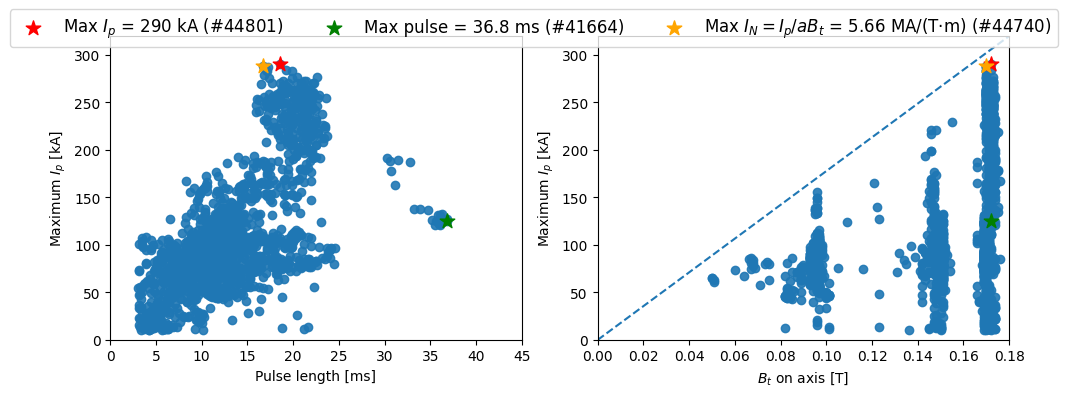

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- data load & filtering ----------------------------------------------------

excel_file = '/home/user1/h5pyd/vaft/workflow/history_data_mining/omas_history_new.xlsx'
df = pd.read_excel(excel_file)

mask1 = (
    (df['pulse_duration'].between(3, 15)) &
    (df['max_plasma_current'].between(193, 250))
)
mask2 = (
    (df['pulse_duration'].between(3, 7)) &
    (df['max_plasma_current'].between(150, 190))
)

df = df[~mask1 & ~mask2]                 # drop two undesired bands
df = df[(df['pulse_duration'] > 3) &     # basic cleaning
        (df['pulse_duration'] < 50) &
        (df['max_plasma_current'] > 10)]

a = 0.3  # 부반경(minor radius) [m]
# I_p의 단위가 kA이므로 MA로 변환하기 위해 1000으로 나눕니다.
# B_t가 0이 되는 경우를 대비하여 np.nan으로 대체하여 계산 오류를 방지합니다.
df['normalized_current'] = (df['max_plasma_current'] / 1000) / (a * df['toroidal_field'].replace(0, np.nan))


# --- find special points ------------------------------------------------------
idx_max_ip   = df['max_plasma_current'].idxmax()
idx_max_len  = df['pulse_duration'].idxmax()
idx_max_in   = df['normalized_current'].idxmax() # 새로운 정규화 전류의 최댓값 인덱스


pt_ip    = df.loc[idx_max_ip]
pt_len   = df.loc[idx_max_len]
pt_in    = df.loc[idx_max_in] # I_N이 최대인 지점의 데이터
in_val   = pt_in['normalized_current'] # 최대 I_N 값


# helper: legend strings
lbl_ip    = f"Max $I_p$ = {pt_ip['max_plasma_current']:.0f} kA (#{pt_ip['shot']})"
lbl_len   = f"Max pulse = {pt_len['pulse_duration']:.1f} ms (#{pt_len['shot']})"
lbl_in    = f"Max $I_N=I_p/aB_t$ = {in_val:.2f} MA/(T·m) (#{pt_in['shot']})"
# lbl_len   = f"Max pulse  | shot {pt_len['shot']} | {pt_len['pulse_duration']:.1f} ms"
# lbl_in = f"Max $I_N$ | shot {pt_in['shot']} | {in_val:.2f} MA/(T·m)"

# --- figure 1: pulse-length vs Ip  &  Bt vs Ip -------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# (a) pulse length vs Ip
axes[0].scatter(df['pulse_duration'], df['max_plasma_current'], alpha=0.9)
axes[0].scatter(pt_ip['pulse_duration'],  pt_ip['max_plasma_current'],
                s=120, marker='*', color='r', label=lbl_ip)
axes[0].scatter(pt_len['pulse_duration'], pt_len['max_plasma_current'],
                s=120, marker='*', color='g', label=lbl_len)
axes[0].scatter(pt_in['pulse_duration'], pt_in['max_plasma_current'],
                s=120, marker='*', color='orange', label=lbl_in)
axes[0].set_xlabel('Pulse length [ms]')
axes[0].set_ylabel('Maximum $I_p$ [kA]')
axes[0].set_xlim(0, 45)
axes[0].set_ylim(0, 320)
# axes[0].legend(frameon=False, fontsize=8)

# (b) Bt vs Ip
axes[1].scatter(df['toroidal_field'], df['max_plasma_current'], alpha=0.9)
axes[1].scatter(pt_ip['toroidal_field'],  pt_ip['max_plasma_current'],
                s=120, marker='*', color='r', label=lbl_ip)
axes[1].scatter(pt_len['toroidal_field'], pt_len['max_plasma_current'],
                s=120, marker='*', color='g', label=lbl_len)
axes[1].scatter(pt_in['toroidal_field'], pt_in['max_plasma_current'],
                s=120, marker='*', color='orange', label=lbl_in)
axes[1].set_xlabel('$B_t$ on axis [T]')
axes[1].set_ylabel('Maximum $I_p$ [kA]')

# reference line: I_p = (320 kA / 0.18 T) × B_t
xline = np.linspace(0, 0.18, 50)
axes[1].plot(xline, 320/0.18 * xline, linestyle='--')
axes[1].set_xlim(0, 0.18)
axes[1].set_ylim(0, 320)
# axes[1].legend(frameon=False, fontsize=8)
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=3, frameon=True, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



Figure 8. Statistical Analysis of VEST Operational Space

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools


df = pd.read_excel('/home/user1/h5pyd/vaft/workflow/history_data_mining/chease_stability_history.xlsx')

# remove wrong df

# remove beta_normal > 0.2
df = df[df['beta_normal'] < 0.2]
mask1 = (df['ideal_stability'] == 'Unstable') & (df['q_axis'] > 2) & (df['q_axis'] < 3)
mask2 = (df['ideal_stability'] == 'Unstable') & (df['q95'] > 6) & (df['q95'] < 8)
mask3 = (df['ideal_stability'] == 'Unstable') & (df['Ip_norm'] > 4) & (df['Ip_norm'] < 5)
df = df[~mask1 & ~mask2 & ~mask3]



def normalized_plasma_current(Ip, a, Bt):
    """
    Calculate normalized plasma current
    
    Parameters:
    Ip : float or np.array
        Plasma current (A)
    R : float or np.array
        Major radius (m)
    a : float or np.array
        Minor radius (m)
    Bt : float or np.array
        Toroidal field (T)
    
    Returns:
    Ip_norm : float or np.array
        Normalized plasma current
    """
    Ip = Ip / 1e6  # Convert A to MA
    Ip_norm = Ip / (a * Bt)
    return Ip_norm

def kink_safety_factor(R, a, kappa, Ip, Bt, type_='ST'):
    """
    Calculate kink safety factor and related parameters following Friedberg 2008,
    Plasma Physics and Fusion Energy (eq. 13.158, p.405), surface‐current model.

    Inputs:
      R      : major radius [m]
      a      : minor radius [m]
      kappa  : elongation
      Ip     : plasma current [A]
      Bt     : toroidal field [T]
      type_  : 'circular', 'conventional' or 'ST'

    Outputs:
      q_kink   : kink safety factor
      q_min    : ballooning‐kink stability limit
      beta_max : equilibrium β/I² limit (unit‐less)
      beta_crit: Troyon limit (unit‐less)
      ip_max   : low‐beta kink limit on Ip [A]
    """
    mu0     = 4 * np.pi * 1e-7
    epsilon = a / R
    # Ip_MA   = Ip / 1e6   # convert A → MA
    Ip_MA = Ip

    if type_ == 'circular':
        # circular cross‐section (kappa → 1)
        q_kink = 2 * np.pi * a**2 * Bt / (mu0 * Ip_MA * R)
        beta_max = (np.pi / 4 / (1))**2 * epsilon        # using q_min=1
        beta_crit = 0.14 * epsilon / q_kink # (13.147)

    elif type_ == 'conventional':
        q_kink = 2 * np.pi * a**2 * kappa * Bt / (mu0 * Ip_MA * R) # (13.160)
        g_factor = (1 / kappa) * (1 + 4 / np.pi**2 * (kappa**2 - 1))
        q_kink *= g_factor
        beta_max  = np.pi**2 / 16 * kappa * epsilon / q_kink**2
        beta_crit = 0.14 * epsilon * kappa / q_kink

    elif type_ == 'ST':
        q_kink = 2 * np.pi * a**2 * Bt / (mu0 * Ip_MA * R) * (1 + kappa**2 / 2) # (13.171)
        beta_max = 0.072 * (1 + kappa**2) / 2 * epsilon
        betaN_braket = 0.03 * (q_kink - 1) / ((3/4)**4 + (q_kink - 1)**4)**0.25
        beta_crit = 5 * betaN_braket * (1 + kappa**2) / 2 * epsilon / q_kink

    else:
        raise ValueError("type_ must be 'circular', 'conventional' or 'ST'")

    q_min  = (1 + kappa) / 2 # (13.162) kink stability limit
    ip_max = q_kink * Ip_MA * 2 / (1 + kappa)  # in MA (13.163)
    ip_max /= 1e6                              # back to A

    return q_kink, q_min, beta_max, beta_crit, ip_max
        
# find Ip [A]
df['Ip'] = df['ip [kA]'] * 1e3

# normalized_plasma_current
df['Ip_norm'] = df['Ip'] / (df['minor_radius [m]'] * -df['b_field_tor_axis [T]']) / 1e6

KeyError: 'Ip_norm'


Plotting in 'ideal_resistive' mode (RDCON)...


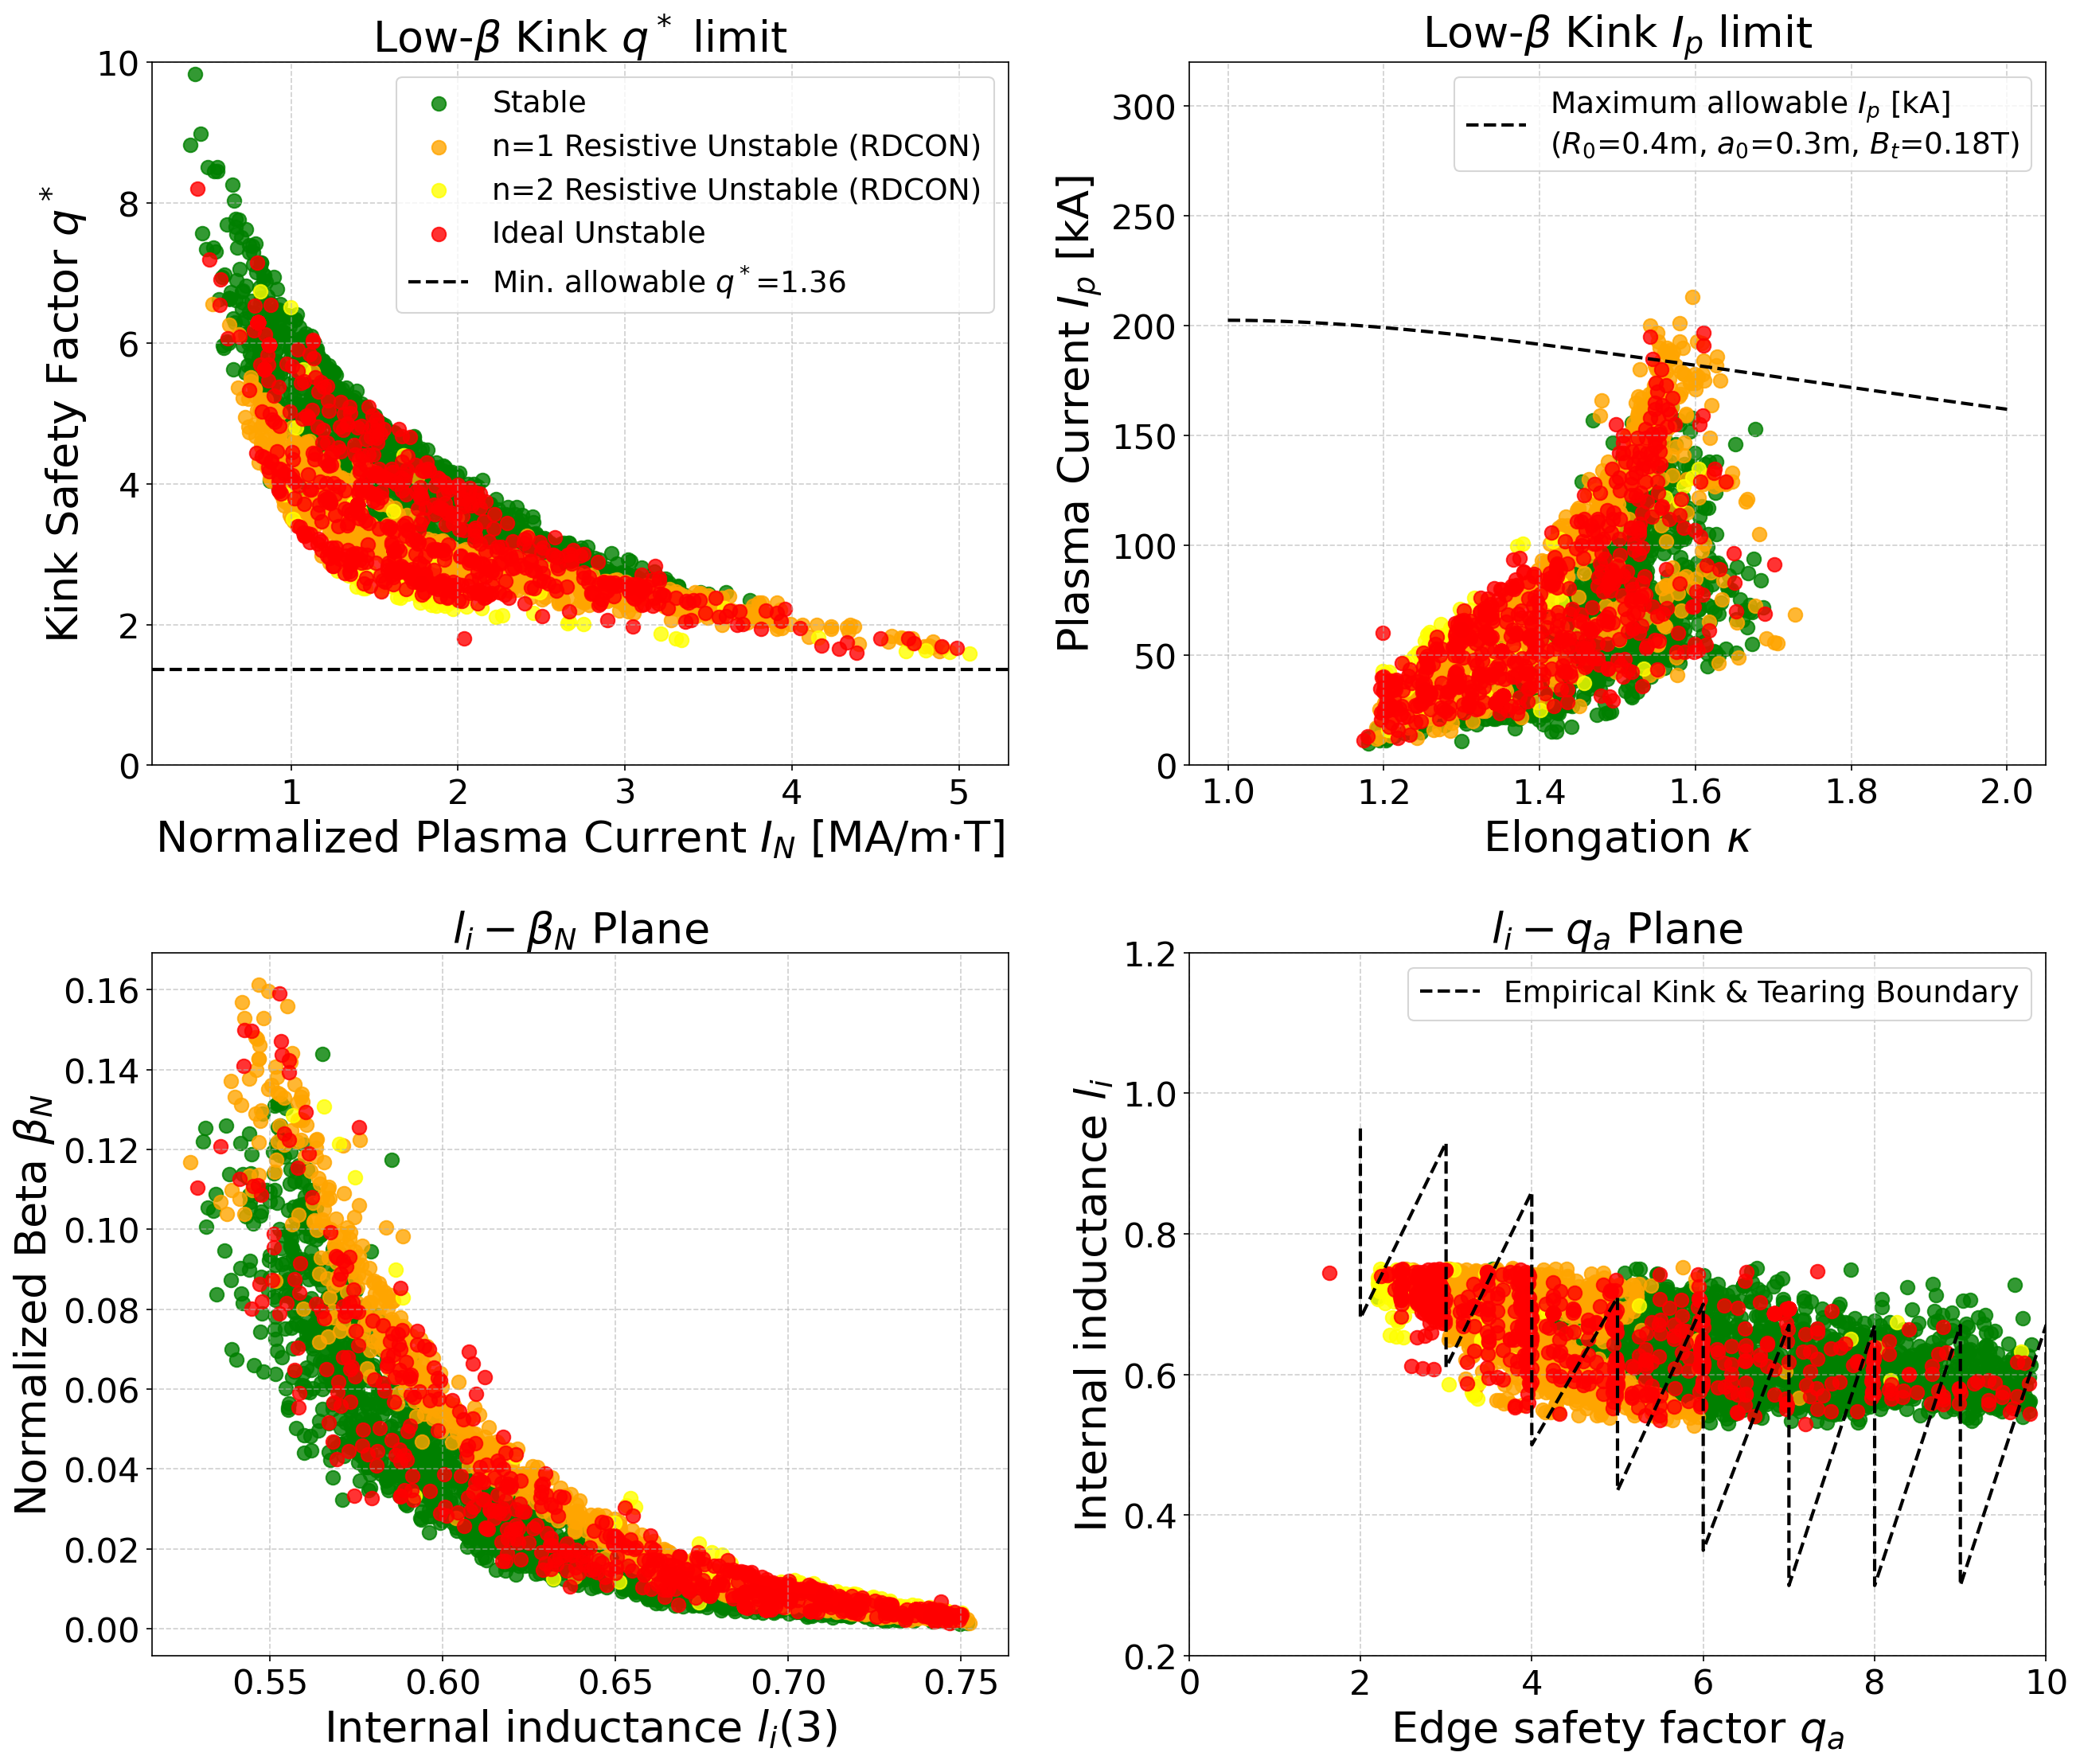

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 아래 두 함수는 원본 코드에 포함되어 있다고 가정합니다.
# 데모를 위해 임시 함수를 정의합니다.

def plot_stability_limits(df=None, input_file=None, mode='ideal_resistive'):
    """
    안정성 한계를 안정성 분류에 따라 색상으로 구분하여 플로팅합니다.

    Args:
        df (pd.DataFrame, optional): 데이터를 포함하는 pandas DataFrame. Defaults to None.
        input_file (str, optional): Excel 파일 경로. df가 None일 경우 사용. Defaults to None.
        mode (str, optional): 플로팅 모드.
                               'ideal': 이상(ideal) 안정 vs 불안정 비교.
                               'resistive': 저항성(resistive) 불안정성(n=1, n=2, n=3)만 표시.
                               'ideal_resistive': 안정, 저항성(n=1, n=2, n=3), 이상 불안정 모두 표시.
                               'resistive_stride': STRIDE 코드를 사용한 저항성 불안정성만 표시.
                               'ideal_resistive_stride': STRIDE 코드를 사용한 'ideal_resistive' 버전.
                               Defaults to 'ideal_resistive'.
    """
    if df is None and input_file:
        print(f"Reading data from {input_file}...")
        df = pd.read_excel(input_file)
    elif df is None and input_file is None:
        raise ValueError("DataFrame 'df' 또는 'input_file' 경로 중 하나를 반드시 제공해야 합니다.")

    df = df.copy()  # 원본 데이터프레임 수정을 방지하기 위해 복사본 사용

    # --- 데이터 전처리 ---
    df['Ip_norm'] = normalized_plasma_current(
        df['ip [kA]'] * 1000,
        df['minor_radius [m]'],
        abs(df['b_field_tor_axis [T]'])
    )
    df['q_kink'], df['q_min'], _, _, _ = kink_safety_factor(
        df['major_radius [m]'],
        df['minor_radius [m]'],
        df['elongation'],
        df['ip [kA]'] * 1000,
        abs(df['b_field_tor_axis [T]'])
    )

    # --- 모드 기반 안정성 분류 ---
    class_titles = {}
    colors = {}
    
    # 기본 분류: 'ideal' 모드
    if mode == 'ideal':
        mask1 = (df['ideal_stability'] == 'Unstable') & (df['q_axis'] > 2) & (df['q_axis'] < 3)
        mask2 = (df['ideal_stability'] == 'Unstable') & (df['q95'] > 6) & (df['q95'] < 8)
        mask3 = (df['ideal_stability'] == 'Unstable') & (df['Ip_norm'] > 4) & (df['Ip_norm'] < 5)
        df = df[~mask1 & ~mask2 & ~mask3]
        
        df['stability_class'] = 'ideal_stable'
        df.loc[df['ideal_stability'] == 'Unstable', 'stability_class'] = 'ideal_unstable'

        colors = {
            'ideal_stable': 'green',
            'ideal_unstable': 'red'
        }
        class_titles = {
            'ideal_stable': 'Ideal Stable',
            'ideal_unstable': 'Ideal Unstable'
        }

    # 저항성 모드 (RDCON 또는 STRIDE)
    elif 'resistive' in mode:
        # 모드에 따라 사용할 열 이름 결정
        if 'stride' in mode:
            n1_col, n2_col, n3_col = 'tearing_index_stride_n1', 'tearing_index_stride_n2', 'tearing_index_stride_n3'
            code_name = "STRIDE"
        else:
            n1_col, n2_col, n3_col = 'tearing_index_rdcon_n1', 'tearing_index_rdcon_n2', 'tearing_index_rdcon_n3'
            code_name = "RDCON"
        
        # 열이 없는 경우를 대비한 예외 처리
        for col in [n1_col, n2_col, n3_col]:
             if col not in df.columns:
                df[col] = 0 # 임시로 0으로 채움

        df['stability_class'] = 'stable'
        
        n1_mask = df[n1_col] > 0
        n2_mask = df[n2_col] > 0
        n3_mask = df[n3_col] > 0
        ideal_mask = df['ideal_stability'] == 'Unstable'
        
        # 우선순위: ideal > n=3 > n=2 > n=1
        df.loc[n1_mask, 'stability_class'] = 'n1_resistive_unstable'
        df.loc[n2_mask, 'stability_class'] = 'n2_resistive_unstable'
        df.loc[n3_mask, 'stability_class'] = 'n3_resistive_unstable'
        df.loc[ideal_mask, 'stability_class'] = 'ideal_unstable'
        
        # 전체 색상 및 라벨 정의
        colors = {
            'stable': 'green',
            'n1_resistive_unstable': 'orange',
            'n2_resistive_unstable': 'yellow',
            'n3_resistive_unstable': 'purple',
            'ideal_unstable': 'red'
        }
        class_titles = {
            'stable': 'Stable',
            'n1_resistive_unstable': f'n=1 Resistive Unstable ({code_name})',
            'n2_resistive_unstable': f'n=2 Resistive Unstable ({code_name})',
            'n3_resistive_unstable': f'n=3 Resistive Unstable ({code_name})',
            'ideal_unstable': 'Ideal Unstable'
        }
        
        # 'resistive' 단독 모드일 경우, 다른 클래스 필터링
        if mode == 'resistive' or mode == 'resistive_stride':
            allowed_classes = ['n1_resistive_unstable', 'n2_resistive_unstable', 'n3_resistive_unstable']
            df = df[df['stability_class'].isin(allowed_classes)]
            # 사용되지 않는 범례 항목 제거
            class_titles.pop('stable', None)
            class_titles.pop('ideal_unstable', None)

    else:
        raise ValueError(f"Invalid mode: '{mode}'. Choose from 'ideal', 'resistive', 'ideal_resistive', 'resistive_stride', 'ideal_resistive_stride'.")

    # --- 플로팅 ---
    fig, ax = plt.subplots(2, 2, figsize=(18, 16))
    fontsize = 26
    legend_fontsize = 18
    plt.rcParams.update({
        'font.size': fontsize,
        'axes.titlesize': fontsize,
        'axes.labelsize': fontsize,
        'xtick.labelsize': fontsize * 0.8,
        'ytick.labelsize': fontsize * 0.8,
        'legend.fontsize': legend_fontsize
    })
    
    scatter_size = 70
    
    # 범례에 표시될 순서대로 클래스를 정렬
    ordered_classes = [k for k in class_titles.keys() if k in df['stability_class'].unique()]
    
    # [0, 0] Balloning-Kink limit
    for stability_class in ordered_classes:
        title = class_titles[stability_class]
        mask = df['stability_class'] == stability_class
        ax[0, 0].scatter(
            df.loc[mask, 'Ip_norm'],
            df.loc[mask, 'q_kink'],
            s=scatter_size,
            color=colors[stability_class],
            label=title,
            alpha=0.8
        )
    ax[0, 0].axhline(y=df['q_min'].max(), color='k', linestyle='--', linewidth=2, label=f'Min. allowable $q^*$={df["q_min"].max():.2f}')
    ax[0, 0].set_xlabel(r'Normalized Plasma Current $I_N$ [MA/m$\cdot$T]')
    ax[0, 0].set_ylabel(r'Kink Safety Factor $q^*$')
    ax[0, 0].set_title(r'Low-$\beta$ Kink $q^*$ limit')
    ax[0, 0].legend()
    ax[0, 0].set_ylim([0, 10])
    ax[0, 0].grid(True, linestyle='--', alpha=0.6)

    # [0, 1] Ip - Elongation limit
    for stability_class in ordered_classes:
        mask = df['stability_class'] == stability_class
        ax[0, 1].scatter(
            df.loc[mask, 'elongation'],
            df.loc[mask, 'ip [kA]'],
            s=scatter_size,
            color=colors[stability_class],
            alpha=0.8
        )
    x = np.linspace(1, 2, 100)
    Bt = 0.18; R = 0.4; a = 0.3; mu0 = 4 * np.pi * 1e-7
    y = 2 * np.pi * a**2 * Bt / (mu0 * R) * (2 * x) / (1 + x**2)
    y = y / 1000 # kA로 변환
    ax[0, 1].plot(x, y, 'k--', linewidth=2, label='Maximum allowable $I_{p}$ [kA]\n($R_0$=0.4m, $a_0$=0.3m, $B_t$=0.18T)')
    ax[0, 1].set_xlabel(r'Elongation $\kappa$')
    ax[0, 1].set_ylabel(r'Plasma Current $I_p$ [kA]')
    ax[0, 1].set_ylim([0, 320])
    ax[0, 1].set_title(r'Low-$\beta$ Kink $I_p$ limit')
    ax[0, 1].legend()
    ax[0, 1].grid(True, linestyle='--', alpha=0.6)
    
    # [1, 0] li - betaN limit
    for stability_class in ordered_classes:
        mask = df['stability_class'] == stability_class
        ax[1, 0].scatter(
            df.loc[mask, 'li_3'],
            df.loc[mask, 'beta_normal'],
            s=scatter_size,
            color=colors[stability_class],
            alpha=0.8
        )
    ax[1, 0].set_xlabel(r'Internal inductance $l_i(3)$')
    ax[1, 0].set_ylabel(r'Normalized Beta $\beta_N$')
    ax[1, 0].set_title(r'$l_i - \beta_N$ Plane')
    ax[1, 0].grid(True, linestyle='--', alpha=0.6)


    # [1, 1] Empirical Kink & double tearing limit
    def empirical_li_qa():
        qa = np.array([2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10])
        li = np.array([0.95, 0.68, 0.93, 0.61, 0.86, 0.5, 0.71, 0.435, 0.7, 0.35, 0.67, 0.3, 0.67, 0.3, 0.67, 0.3, 0.67, 0.3])
        return qa, li
    qa_line, li_line = empirical_li_qa()

    for stability_class in ordered_classes:
        mask = df['stability_class'] == stability_class
        ax[1, 1].scatter(
            df.loc[mask, 'qlim'],
            df.loc[mask, 'li_3'],
            s=scatter_size,
            color=colors[stability_class],
            alpha=0.8
        )
    ax[1, 1].plot(qa_line, li_line, 'k--', linewidth=2, label='Empirical Kink & Tearing Boundary')
    ax[1, 1].set_xlabel(r'Edge safety factor $q_a$')
    ax[1, 1].set_ylabel(r'Internal inductance $l_i$')
    ax[1, 1].set_title('$l_i-q_a$ Plane')
    ax[1, 1].set_xlim([0, 10])
    ax[1, 1].set_ylim([0.2, 1.2])
    ax[1, 1].legend()
    ax[1, 1].grid(True, linestyle='--', alpha=0.6)

    # 전체 그림에 대한 하나의 범례 생성 (선택 사항)
    # handles, labels = [], []
    # for ax_ in fig.axes:
    #     for h, l in zip(*ax_.get_legend_handles_labels()):
    #         if l not in labels:
    #             handles.append(h)
    #             labels.append(l)
    # fig.legend(handles, labels, loc='upper center', ncol=len(class_titles), bbox_to_anchor=(0.5, 1.05))

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # 범례 공간 확보 시
    plt.show()

# --- 예제 사용법 ---
# 아래와 같이 가상의 데이터프레임을 만들고 함수를 호출하여 테스트할 수 있습니다.
if __name__ == '__main__':
    # 가상 데이터 생성

    # 3. Ideal + Resistive 모드 (RDCON): 모든 안정성 표시
    print("\nPlotting in 'ideal_resistive' mode (RDCON)...")
    plot_stability_limits(df=df, mode='ideal_resistive')
    
    # 4. Resistive 모드 (STRIDE): STRIDE 코드 기반 저항성 불안정성만 표시
    # print("\nPlotting in 'resistive_stride' mode...")
    # plot_stability_limits(df=mock_df, mode='resistive_stride')

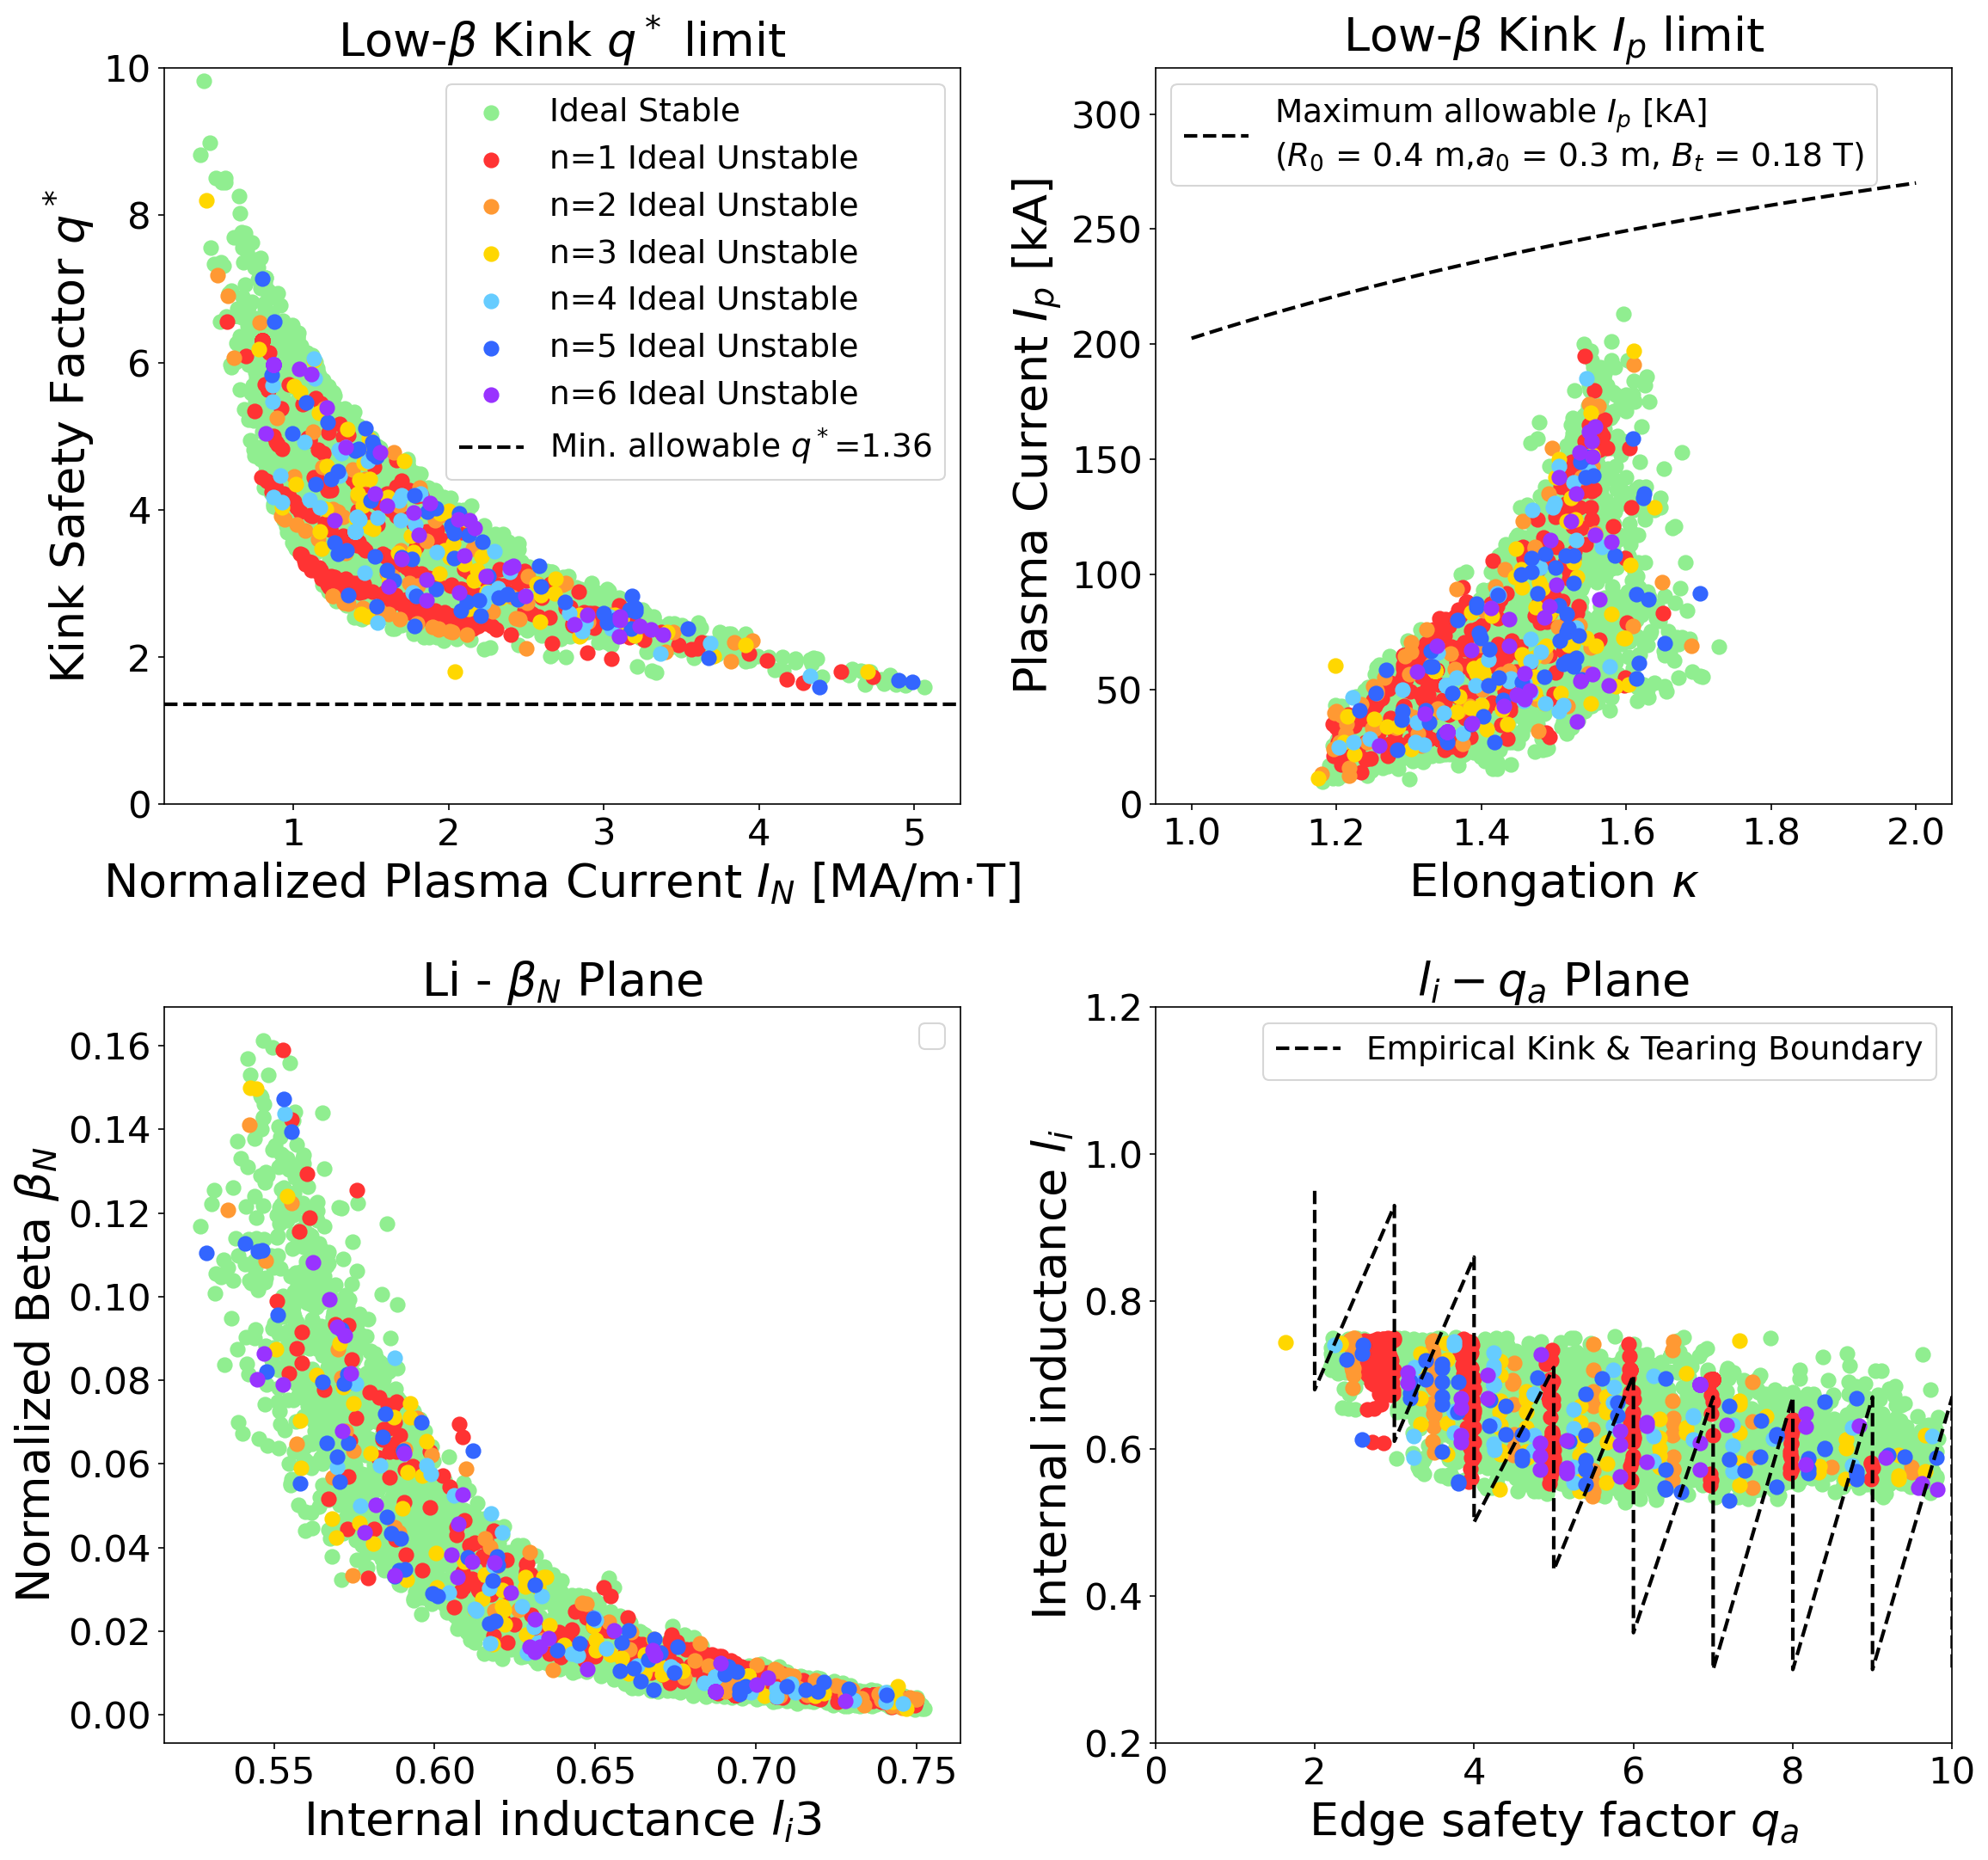

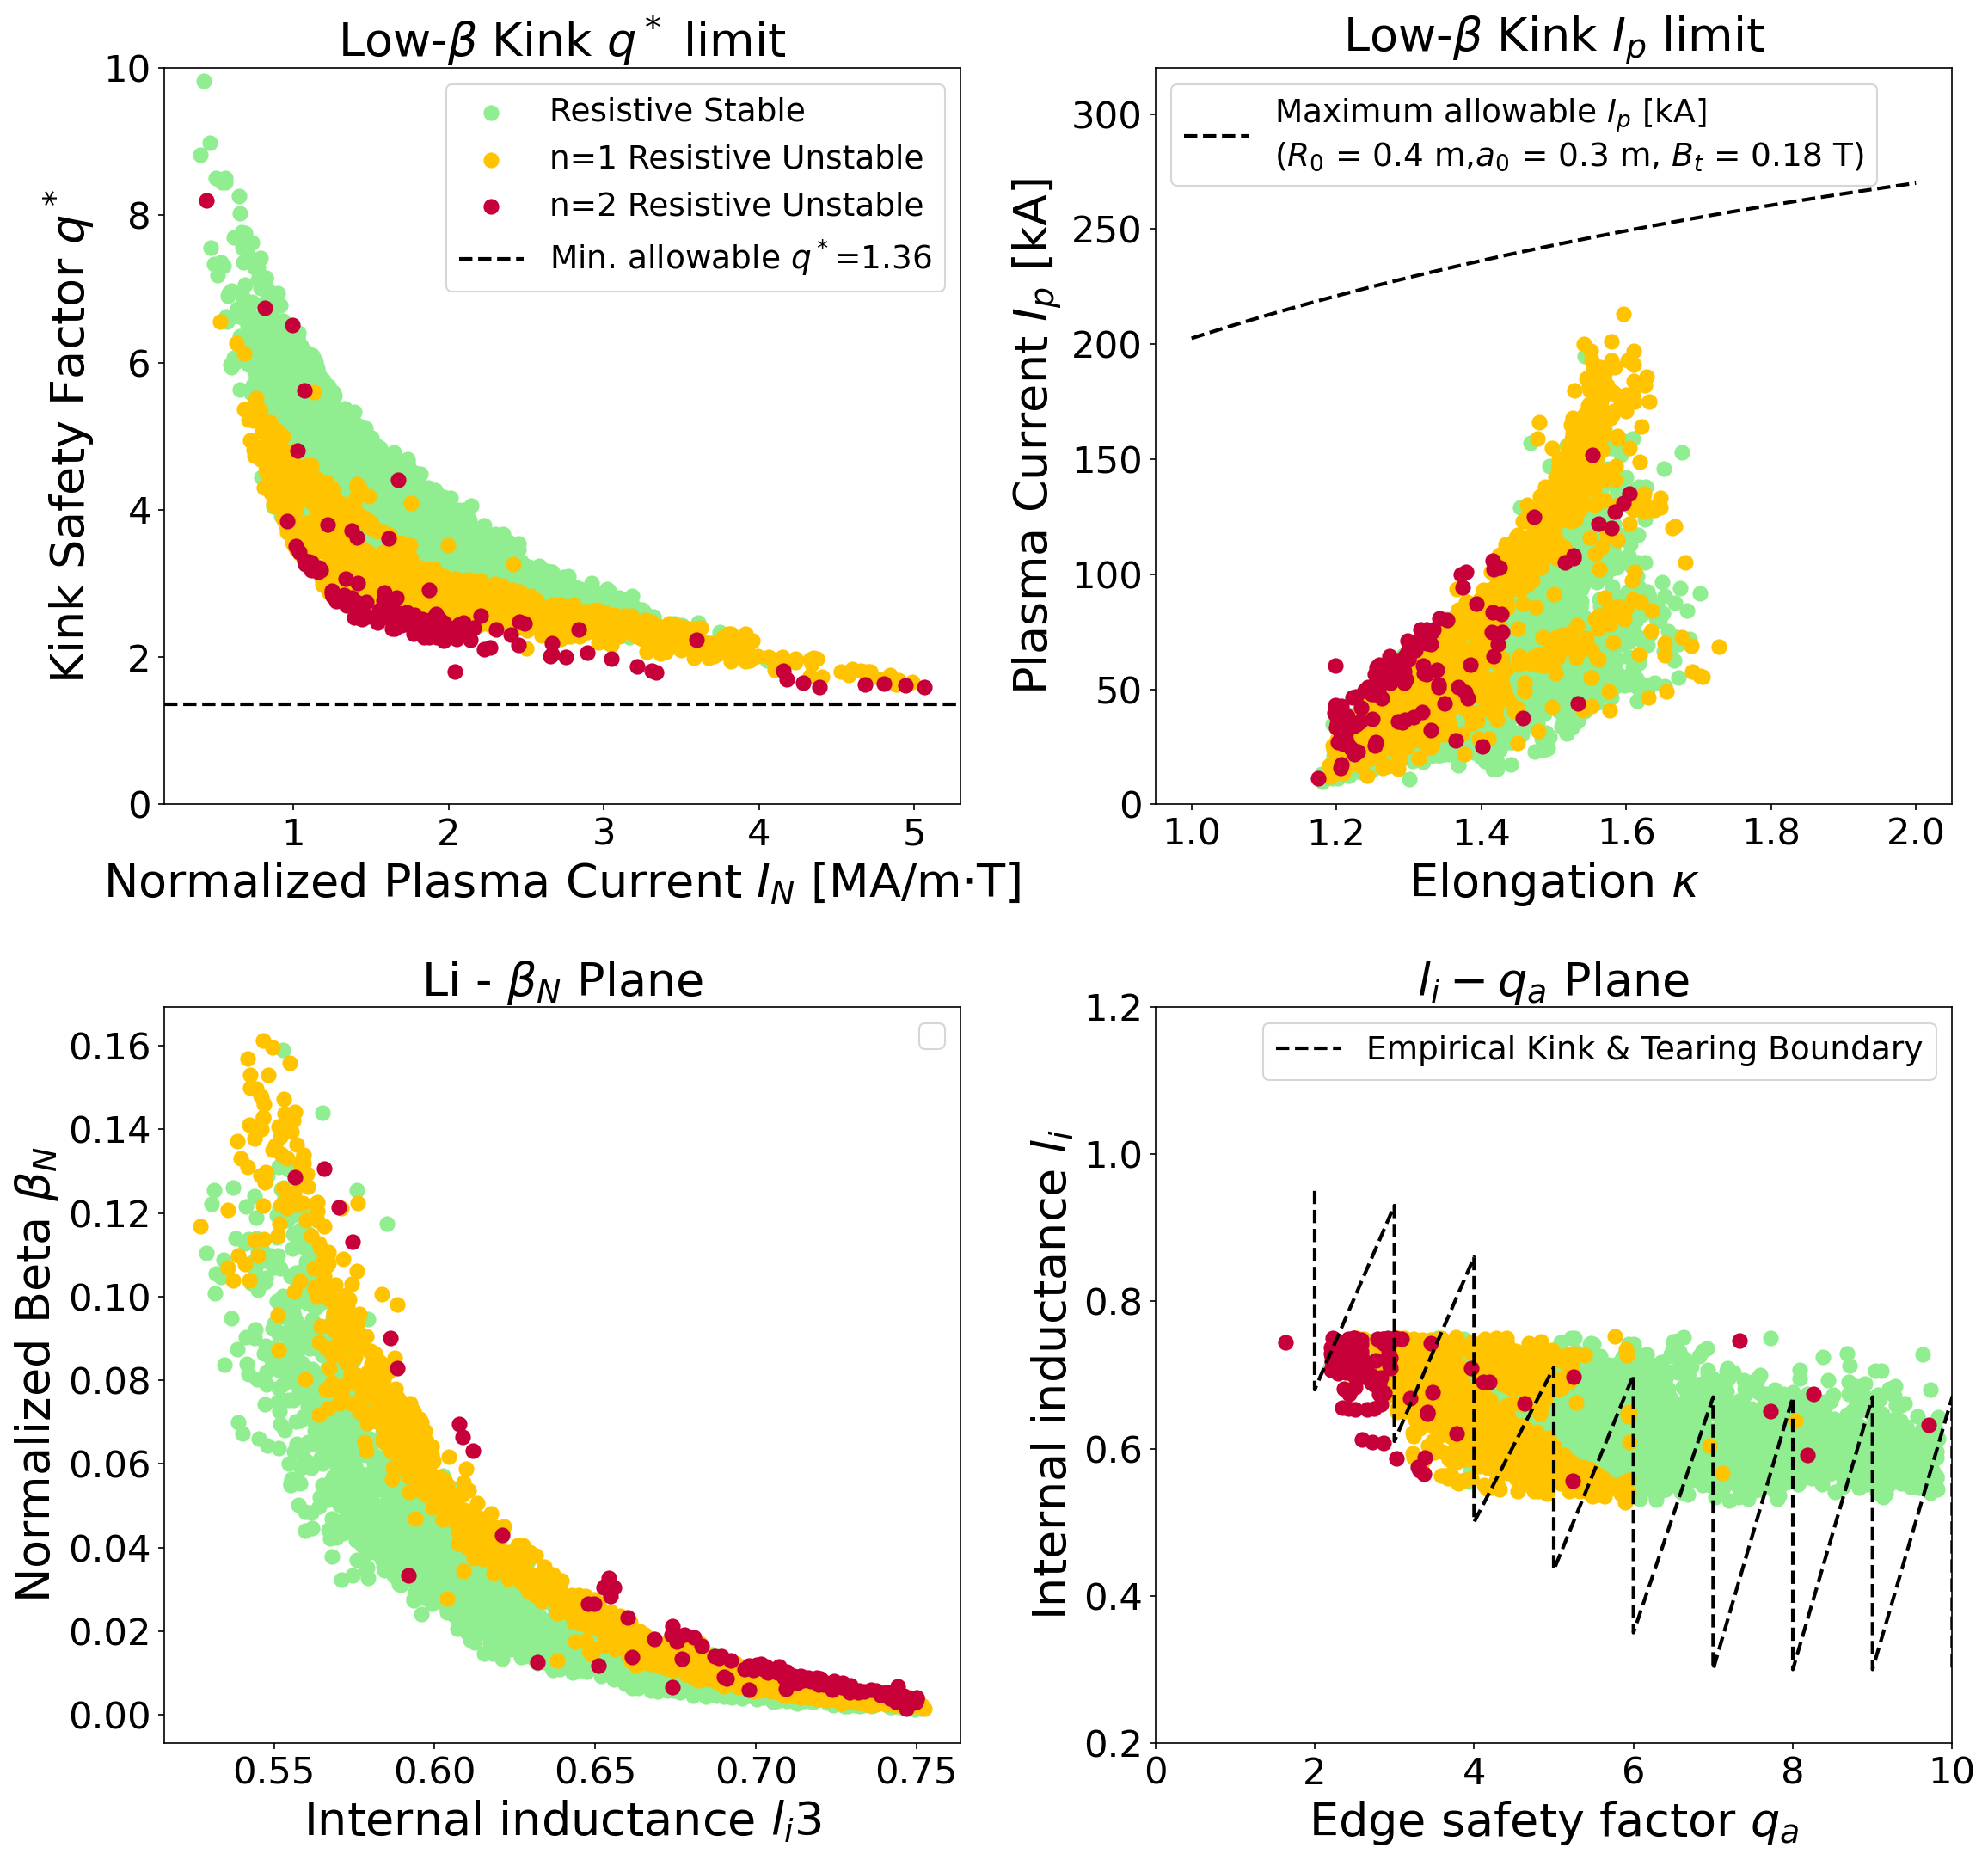

In [ ]:
def plot_stability_limits(df=None, input_file=None, mode='resistve'):
    """
    Plot stability limits with stability classification coloring.

    Args:
        df (pd.DataFrame, optional): A pandas DataFrame containing the data. Defaults to None.
        input_file (str, optional): Path to the Excel file. Used if df is None. Defaults to None.
        mode (str, optional): Plotting mode. 
                               'ideal' -> Compares ideal stable vs. unstable.
                               'ideal_resistive' -> Compares stable, n1/n2 resistive, and ideal unstable.
                               Defaults to 'ideal_resistive'.
    """
    if df is None and input_file:
        print(f"Reading data from {input_file}...")
        df = pd.read_excel(input_file)
    elif df is None and input_file is None:
        raise ValueError("Either a DataFrame 'df' or an 'input_file' path must be provided.")

    df = df.copy() # 원본 데이터프레임 수정을 방지하기 위해 복사본 사용
                     # Use a copy to avoid modifying the original DataFrame

    # --- Data Pre-processing ---

    # Calculate normalized plasma current
    df['Ip_norm'] = normalized_plasma_current(
        df['ip [kA]'] * 1000,  # Convert kA to A
        df['minor_radius [m]'],
        abs(df['b_field_tor_axis [T]'])
    )
    
    # Calculate kink safety factor
    df['q_kink'], df['q_min'], _, _, _ = kink_safety_factor(
        df['major_radius [m]'],
        df['minor_radius [m]'],
        df['elongation'],
        df['ip [kA]'] * 1000,  # Convert kA to A
        abs(df['b_field_tor_axis [T]'])
    )

    # --- Mode-based Stability Classification ---
    
    if mode == 'ideal':
        # 첫 번째 함수의 필터링 및 분류 로직
        # Filtering and classification logic from the first function


        n1_mask = df['delta_w_n1'] < 0
        n2_mask = df['delta_w_n2'] < 0
        n3_mask = df['delta_w_n3'] < 0
        n4_mask = df['delta_w_n4'] < 0
        n5_mask = df['delta_w_n5'] < 0
        n6_mask = df['delta_w_n6'] < 0
        df.loc[n1_mask, 'stability_class'] = 'n1_ideal_unstable'
        df.loc[~n1_mask & n2_mask, 'stability_class'] = 'n2_ideal_unstable'
        df.loc[~n1_mask & ~n2_mask & n3_mask, 'stability_class'] = 'n3_ideal_unstable'
        df.loc[~n1_mask & ~n2_mask & ~n3_mask & n4_mask, 'stability_class'] = 'n4_ideal_unstable'
        df.loc[~n1_mask & ~n2_mask & ~n3_mask & ~n4_mask & n5_mask, 'stability_class'] = 'n5_ideal_unstable'
        df.loc[~n1_mask & ~n2_mask & ~n3_mask & ~n4_mask & ~n5_mask & n6_mask, 'stability_class'] = 'n6_ideal_unstable'

        df.loc[~n1_mask & ~n2_mask & ~n3_mask & ~n4_mask & ~n5_mask & ~n6_mask, 'stability_class'] = 'stable'

        colors = {
            'stable': 'lightgreen',
            'n1_ideal_unstable': '#FF3333', # 밝은 빨강 (Strong Red)
            'n2_ideal_unstable': '#FF9933', # 주황 (Orange)
            'n3_ideal_unstable': '#FFD700', # 골드/노랑 (Gold/Yellow)
            'n4_ideal_unstable': '#66CCFF', # 하늘색 (Sky Blue)
            'n5_ideal_unstable': '#3366FF', # 로얄 블루 (Royal Blue)
            'n6_ideal_unstable': '#9933FF', # 보라 (Purple)
        }

        class_titles = {
            'stable': 'Ideal Stable',
            'n1_ideal_unstable': 'n=1 Ideal Unstable',
            'n2_ideal_unstable': 'n=2 Ideal Unstable',
            'n3_ideal_unstable': 'n=3 Ideal Unstable',
            'n4_ideal_unstable': 'n=4 Ideal Unstable',
            'n5_ideal_unstable': 'n=5 Ideal Unstable',
            'n6_ideal_unstable': 'n=6 Ideal Unstable',
        }

        # df['stability_class'] = 'ideal_stable'
        # df.loc[df['ideal_stability'] == 'Unstable', 'stability_class'] = 'ideal_unstable'

        # colors = {
        #     'ideal_stable': 'green',
        #     'ideal_unstable': 'red'
        # }
        # class_titles = {
        #     'ideal_stable': 'Ideal Stable',
        #     'ideal_unstable': 'Ideal Unstable'
        # }

    elif mode == 'ideal_resistive':
        # 두 번째 함수의 분류 로직
        # Classification logic from the second function
        df['stability_class'] = 'stable'
        
        n1_mask = df['tearing_index_rdcon_n1'] > 0
        n2_mask = df['tearing_index_rdcon_n2'] > 0
        ideal_mask = df['delta_w_n1'] < 0
        # ideal_mask = df['ideal_stability'] == 'Unstable'
        
        df.loc[~ideal_mask & ~n2_mask & n1_mask, 'stability_class'] = 'n1_resistive_unstable'
        df.loc[~ideal_mask & n2_mask, 'stability_class'] = 'n2_resistive_unstable'
        df.loc[ideal_mask, 'stability_class'] = 'ideal_unstable'
        
        colors = {
            'stable': 'green',
            'n1_resistive_unstable': 'orange',
            'ideal_unstable': 'red',
            'n2_resistive_unstable': 'yellow',
            'ideal_unstable': 'red'
        }
        class_titles = {
            'stable': 'Stable',
            'n1_resistive_unstable': 'n=1 Resistive Unstable (RDCON)',
            'ideal_unstable': 'n=1 Ideal Unstable (DCON)',
            'n2_resistive_unstable': 'n=2 Resistive Unstable (RDCON)',
        }
    elif mode == 'resistive':
        df['stability_class'] = 'stable'
        
        n1_mask = df['tearing_index_rdcon_n1'] > 0
        n2_mask = df['tearing_index_rdcon_n2'] > 0

        df.loc[n1_mask, 'stability_class'] = 'n1_resistive_unstable'
        df.loc[n2_mask, 'stability_class'] = 'n2_resistive_unstable'
        df.loc[~n1_mask & ~n2_mask, 'stability_class'] = 'stable'

        colors = {
            'stable': 'lightgreen',
            'n1_resistive_unstable': '#FFC300', # 금색 (Gold)
            'n2_resistive_unstable': '#C70039', # 다홍색 (Crimson)
        }
        class_titles = {
            'stable': 'Resistive Stable',
            'n1_resistive_unstable': 'n=1 Resistive Unstable',
            'n2_resistive_unstable': 'n=2 Resistive Unstable',
        }
    elif mode == 'ideal_resistive_stride':
        df['stability_class'] = 'stable'
        
        n1_mask = df['tearing_index_stride_n1'] > 0
        n2_mask = df['tearing_index_stride_n2'] > 0
        ideal_mask = df['ideal_stability'] == 'Unstable'
        
        df.loc[~ideal_mask & ~n2_mask & n1_mask, 'stability_class'] = 'n1_resistive_unstable'
        df.loc[~ideal_mask & n2_mask, 'stability_class'] = 'n2_resistive_unstable'
        df.loc[ideal_mask, 'stability_class'] = 'ideal_unstable'

        colors = {
            'stable': 'green',
            'n1_resistive_unstable': 'orange',
            'n2_resistive_unstable': 'yellow',
            'ideal_unstable': 'red'
        }
        class_titles = {
            'stable': 'Stable',
            'n1_resistive_unstable': 'n=1 Resistive Unstable (STRIDE)',
            'n2_resistive_unstable': 'n=2 Resistive Unstable (STRIDE)',
            'ideal_unstable': 'Ideal Unstable'
        }
        
    else:
        raise ValueError(f"Invalid mode: '{mode}'. Choose 'ideal' or 'ideal_resistive'.")

    # --- Plotting ---
    fig, ax = plt.subplots(2, 2, figsize=(16, 15))
    fontsize = 26
    legend_fontsize = 18
    plt.rcParams.update({
        'font.size': fontsize,
        'axes.titlesize': fontsize,
        'axes.labelsize': fontsize,
        'xtick.labelsize': fontsize * 0.8,
        'ytick.labelsize': fontsize * 0.8,
        'legend.fontsize': legend_fontsize
    })
    
    scatter_size = 60
    
    # [0, 0] Balloning-Kink limit
    for stability_class, title in class_titles.items():
        mask = df['stability_class'] == stability_class
        ax[0, 0].scatter(
            df.loc[mask, 'Ip_norm'],
            df.loc[mask, 'q_kink'],
            s=scatter_size,
            color=colors[stability_class],
            label=title
        )
    ax[0, 0].axhline(y=df['q_min'].max(), color='k', linestyle='--', linewidth=2, label=f'Min. allowable $q^*$={df["q_min"].max():.2f}')
    ax[0, 0].set_xlabel(r'Normalized Plasma Current $I_N$ [MA/m$\cdot$T]')
    ax[0, 0].set_ylabel(r'Kink Safety Factor $q^*$')
    ax[0, 0].set_title(r'Low-$\beta$ Kink $q^*$ limit')
    ax[0, 0].legend()
    ax[0, 0].set_ylim([0, 10])

    for stability_class, title in class_titles.items():
        mask = df['stability_class'] == stability_class
        ax[0, 1].scatter(
            df.loc[mask, 'elongation'],
            df.loc[mask, 'ip [kA]'],
            s=scatter_size,
            color=colors[stability_class],
            # label=title
        )
    x = np.linspace(1, 2, 100)
    Bt = 0.18
    R = 0.4
    a = 0.3
    mu0 = 4 * np.pi * 1e-7
    y = 2 * np.pi * a**2 * Bt / (mu0 * R) * 2 * x / (1+x) # I_max = 2 * np.pi * a**2 * Bt / (mu0 * R) * 2 * kappa / (1+kappa)
    # convert to kA
    y = y / 1000
    ax[0, 1].plot(x, y, 'k--', linewidth=2, label='Maximum allowable $I_{p}$ [kA]\n($R_0$ = 0.4 m,$a_0$ = 0.3 m, $B_t$ = 0.18 T)')

    ax[0, 1].set_xlabel(r'Elongation $\kappa$')
    ax[0, 1].set_ylabel(r'Plasma Current $I_p$ [kA]')
    ax[0, 1].set_ylim([0, 320])
    ax[0, 1].set_title(r'Low-$\beta$ Kink $I_p$ limit')
    ax[0, 1].legend()

    # [1, 0] Sawtooth limit
    # for stability_class, title in class_titles.items():
    #     mask = df['stability_class'] == stability_class
    #     ax[1, 0].scatter(
    #         df.loc[mask, 'ip [kA]'],
    #         df.loc[mask, 'q_axis'],
    #         s=scatter_size,
    #         color=colors[stability_class]
    #         # label=title # 범례가 너무 많아져서 생략
    #     )
    # ax[1, 0].axhline(y=1, color='k', linestyle='--', linewidth=2, label='$q_0=1$')
    # ax[1, 0].set_xlabel(r'Plasma Current $I_p$ [kA]')
    # ax[1, 0].set_ylabel(r'Axis safety factor $q_0$')
    # ax[1, 0].set_title('Sawtooth limit')
    # ax[1, 0].set_ylim([0, 8])
    # ax[1, 0].legend()
    # [1, 0] li - betaN limit
    for stability_class, title in class_titles.items():
        mask = df['stability_class'] == stability_class
        ax[1, 0].scatter(
            df.loc[mask, 'li_3'],
            df.loc[mask, 'beta_normal'],
            s=scatter_size,
            color=colors[stability_class],
            # label=title
        )
    ax[1, 0].set_xlabel(r'Internal inductance $l_i3$')
    ax[1, 0].set_ylabel(r'Normalized Beta $\beta_N$')
    ax[1, 0].set_title(r'Li - $\beta_N$ Plane')
    ax[1, 0].legend()

    
    # [1, 1] Empirical Kink & double tearing limit
    def empirical_li_qa():
        qa = np.array([2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10])
        li = np.array([0.95, 0.68, 0.93, 0.61, 0.86, 0.5, 0.71, 0.435, 0.7, 0.35, 0.67, 0.3, 0.67, 0.3, 0.67, 0.3, 0.67, 0.3])
        return qa, li
    qa_line, li_line = empirical_li_qa()

    for stability_class, title in class_titles.items():
        mask = df['stability_class'] == stability_class
        ax[1, 1].scatter(
            df.loc[mask, 'qlim'],
            df.loc[mask, 'li_3'],
            s=scatter_size,
            color=colors[stability_class],
            # label=title
        )
    ax[1, 1].plot(qa_line, li_line, 'k--', linewidth=2, label='Empirical Kink & Tearing Boundary')
    ax[1, 1].set_xlabel(r'Edge safety factor $q_a$')
    ax[1, 1].set_ylabel(r'Internal inductance $l_i$')
    ax[1, 1].set_title('$l_i-q_a$ Plane')
    ax[1, 1].set_xlim([0, 10])
    ax[1, 1].set_ylim([0.2, 1.2])
    ax[1, 1].legend()

    plt.tight_layout()
    plt.show()
plot_stability_limits(df, input_file=None, mode='ideal')
plot_stability_limits(df, input_file=None, mode='resistive')
# plot_stability_limits(df, input_file=None, mode='ideal_resistive_stride')

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def plot_stability_limits_delta_prime_grid(input_file, code, nmode, vmin=None, vmax=None, cmap='viridis'):
    """
    2x2 그리드에 안정성 한계를 플롯하고, 컬러바 위치를 정확하게 조정합니다.
    컬러맵(cmap)과 색상 범위(vmin, vmax)를 인자로 받아 동적으로 설정할 수 있습니다.

    Args:
        input_file (str): 입력 데이터 엑셀 파일 경로.
        code (str): 안정성 코드 이름 (예: 'rdcon', 'stride').
        nmode (int): 토로이달 모드 번호 (예: 1, 2).
        vmin (float, optional): 컬러바의 최솟값. 기본값은 None.
        vmax (float, optional): 컬러바의 최댓값. 기본값은 None.
        cmap (str, optional): 사용할 컬러맵 이름. 기본값은 'viridis'.
    """
    # 1. 데이터 읽기 및 칼럼 준비
    print(f"Reading data from {input_file}...")
    df = pd.read_excel(input_file)
    caxis_column = f'tearing_index_{code}_n{nmode}'
    if caxis_column not in df.columns:
        print(f"Error: Column '{caxis_column}' not found.")
        return

    # 2. 물리 파라미터 계산 (이전과 동일)
    # Calculate normalized plasma current
    df['Ip_norm'] = normalized_plasma_current(
        df['ip [kA]'] * 1000,  # Convert kA to A
        df['minor_radius [m]'],
        abs(df['b_field_tor_axis [T]'])
    )
    
    # Calculate kink safety factor
    df['q_kink'], df['q_min'], df['beta_max'], df['beta_crit'], df['ip_max'] = kink_safety_factor(
        df['major_radius [m]'],
        df['minor_radius [m]'],
        df['elongation'],
        df['ip [kA]'] * 1000,  # Convert kA to A
        abs(df['b_field_tor_axis [T]'])
    )

    # 3. 플롯 생성
    fig, axes = plt.subplots(2, 2, figsize=(18, 16))
    fontsize = 22
    plt.rcParams.update({'font.size': fontsize, 'axes.titlesize': fontsize, 'axes.labelsize': fontsize, 'xtick.labelsize': fontsize * 0.8, 'ytick.labelsize': fontsize * 0.8})
    scatter_size = 70
    
    # --- 각 서브플롯 그리기 (vmin, vmax, cmap 인자 적용) ---
    
    # 색상 정보를 담을 mappable 객체. 어느 scatter에서든 하나만 가져오면 됨.
    mappable = axes[0, 0].scatter(df['Ip_norm'], df['q_kink'], s=scatter_size, c=df[caxis_column], cmap=cmap, vmin=vmin, vmax=vmax)
    if 'q_min' in df and not df['q_min'].empty:
        axes[0, 0].axhline(y=df['q_min'].max(), color='k', linestyle='--', linewidth=2)
    axes[0, 0].set(xlabel=r'Normalized Plasma Current $I_N$ [MA/m$\cdot$T]', ylabel=r'Kink Safety Factor $q^*$', title='Balloning-Kink limit')
    axes[0, 0].set_ylim([0, 10])







    # draw kappa vs I_p
    axes[0, 1].scatter(df['elongation'], df['ip [kA]'], s=scatter_size, c=df[caxis_column], cmap=cmap, vmin=vmin, vmax=vmax)
    axes[0, 1].set_xlabel(r'Elongation $\kappa$')
    axes[0, 1].set_ylabel(r'Plasma Current $I_p$ [kA]')
    axes[0, 1].set_title(r'Low-$\beta$ Kink $I_p$ limit')

    x = np.linspace(1, 2, 100)
    Bt = 0.18
    R = 0.4
    a = 0.3
    mu0 = 4 * np.pi * 1e-7
    y = 2 * np.pi * a**2 * Bt / (mu0 * R) * 2 * x / (1+x) # I_max = 2 * np.pi * a**2 * Bt / (mu0 * R) * 2 * kappa / (1+kappa)
    # convert to kA
    y = y / 1000
    axes[0, 1].plot(x, y, 'k--', linewidth=2, label='Maximum allowable $I_{p}$ \n($R_0$ = 0.4 m,$a_0$ = 0.3 m, $B_t$ = 0.18 T)')


    axes[1, 0].scatter(df['ip [kA]'], df['q_axis'], s=scatter_size, c=df[caxis_column], cmap=cmap, vmin=vmin, vmax=vmax)
    axes[1, 0].axhline(y=1, color='k', linestyle='--', linewidth=2)
    axes[1, 0].set(xlabel=r'Plasma Current $I_p$ [kA]', ylabel=r'Axis safety factor $q_0$', title='Sawtooth limit', ylim=(0, None))


    def empirical_li_qa():
        qa = np.array([2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10]); li = np.array([0.95,0.68,0.93,0.61,0.86,0.5,0.71,0.435,0.7,0.35,0.67,0.3,0.67,0.3,0.67,0.3,0.67,0.3]); return qa, li
    qa_line, li_line = empirical_li_qa()
    axes[1, 1].scatter(df['q95'], df['li_3'], s=scatter_size, c=df[caxis_column], cmap=cmap, vmin=vmin, vmax=vmax)
    axes[1, 1].plot(qa_line, li_line, 'k--', linewidth=2.5)
    axes[1, 1].set(xlabel=r'Edge safety factor $q_{95}$', ylabel=r'Normalized plasma inductance $l_i$', title='Empirical Kink & double tearing limit', xlim=(0, None), ylim=(0, None))

    # 4. 전체 그림에 대한 설정 및 레이아웃 조정 (이전과 동일)
    fig.suptitle(f"Stability Limits Colored by Tearing Index ($\Delta'$) from {code.upper()}, n={nmode}", fontsize=fontsize*1.2)
    fig.tight_layout(rect=[0, 0.03, 0.88, 0.96])
    cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
    cbar = fig.colorbar(mappable, cax=cbar_ax)
    cbar.set_label(r"Tearing Index ($\Delta'$)")
    
    plt.show()



input_file="/home/user1/h5pyd/vaft/workflow/history_data_mining/chease_dcon_history.xlsx"
# code = 'rdcon'
# nmode = 1
# plot_stability_limits_delta_prime_grid(input_file, code, nmode, vmin=-50, vmax=50, cmap='seismic')

Reading data from /home/user1/h5pyd/vaft/workflow/history_data_mining/chease_dcon_history.xlsx...


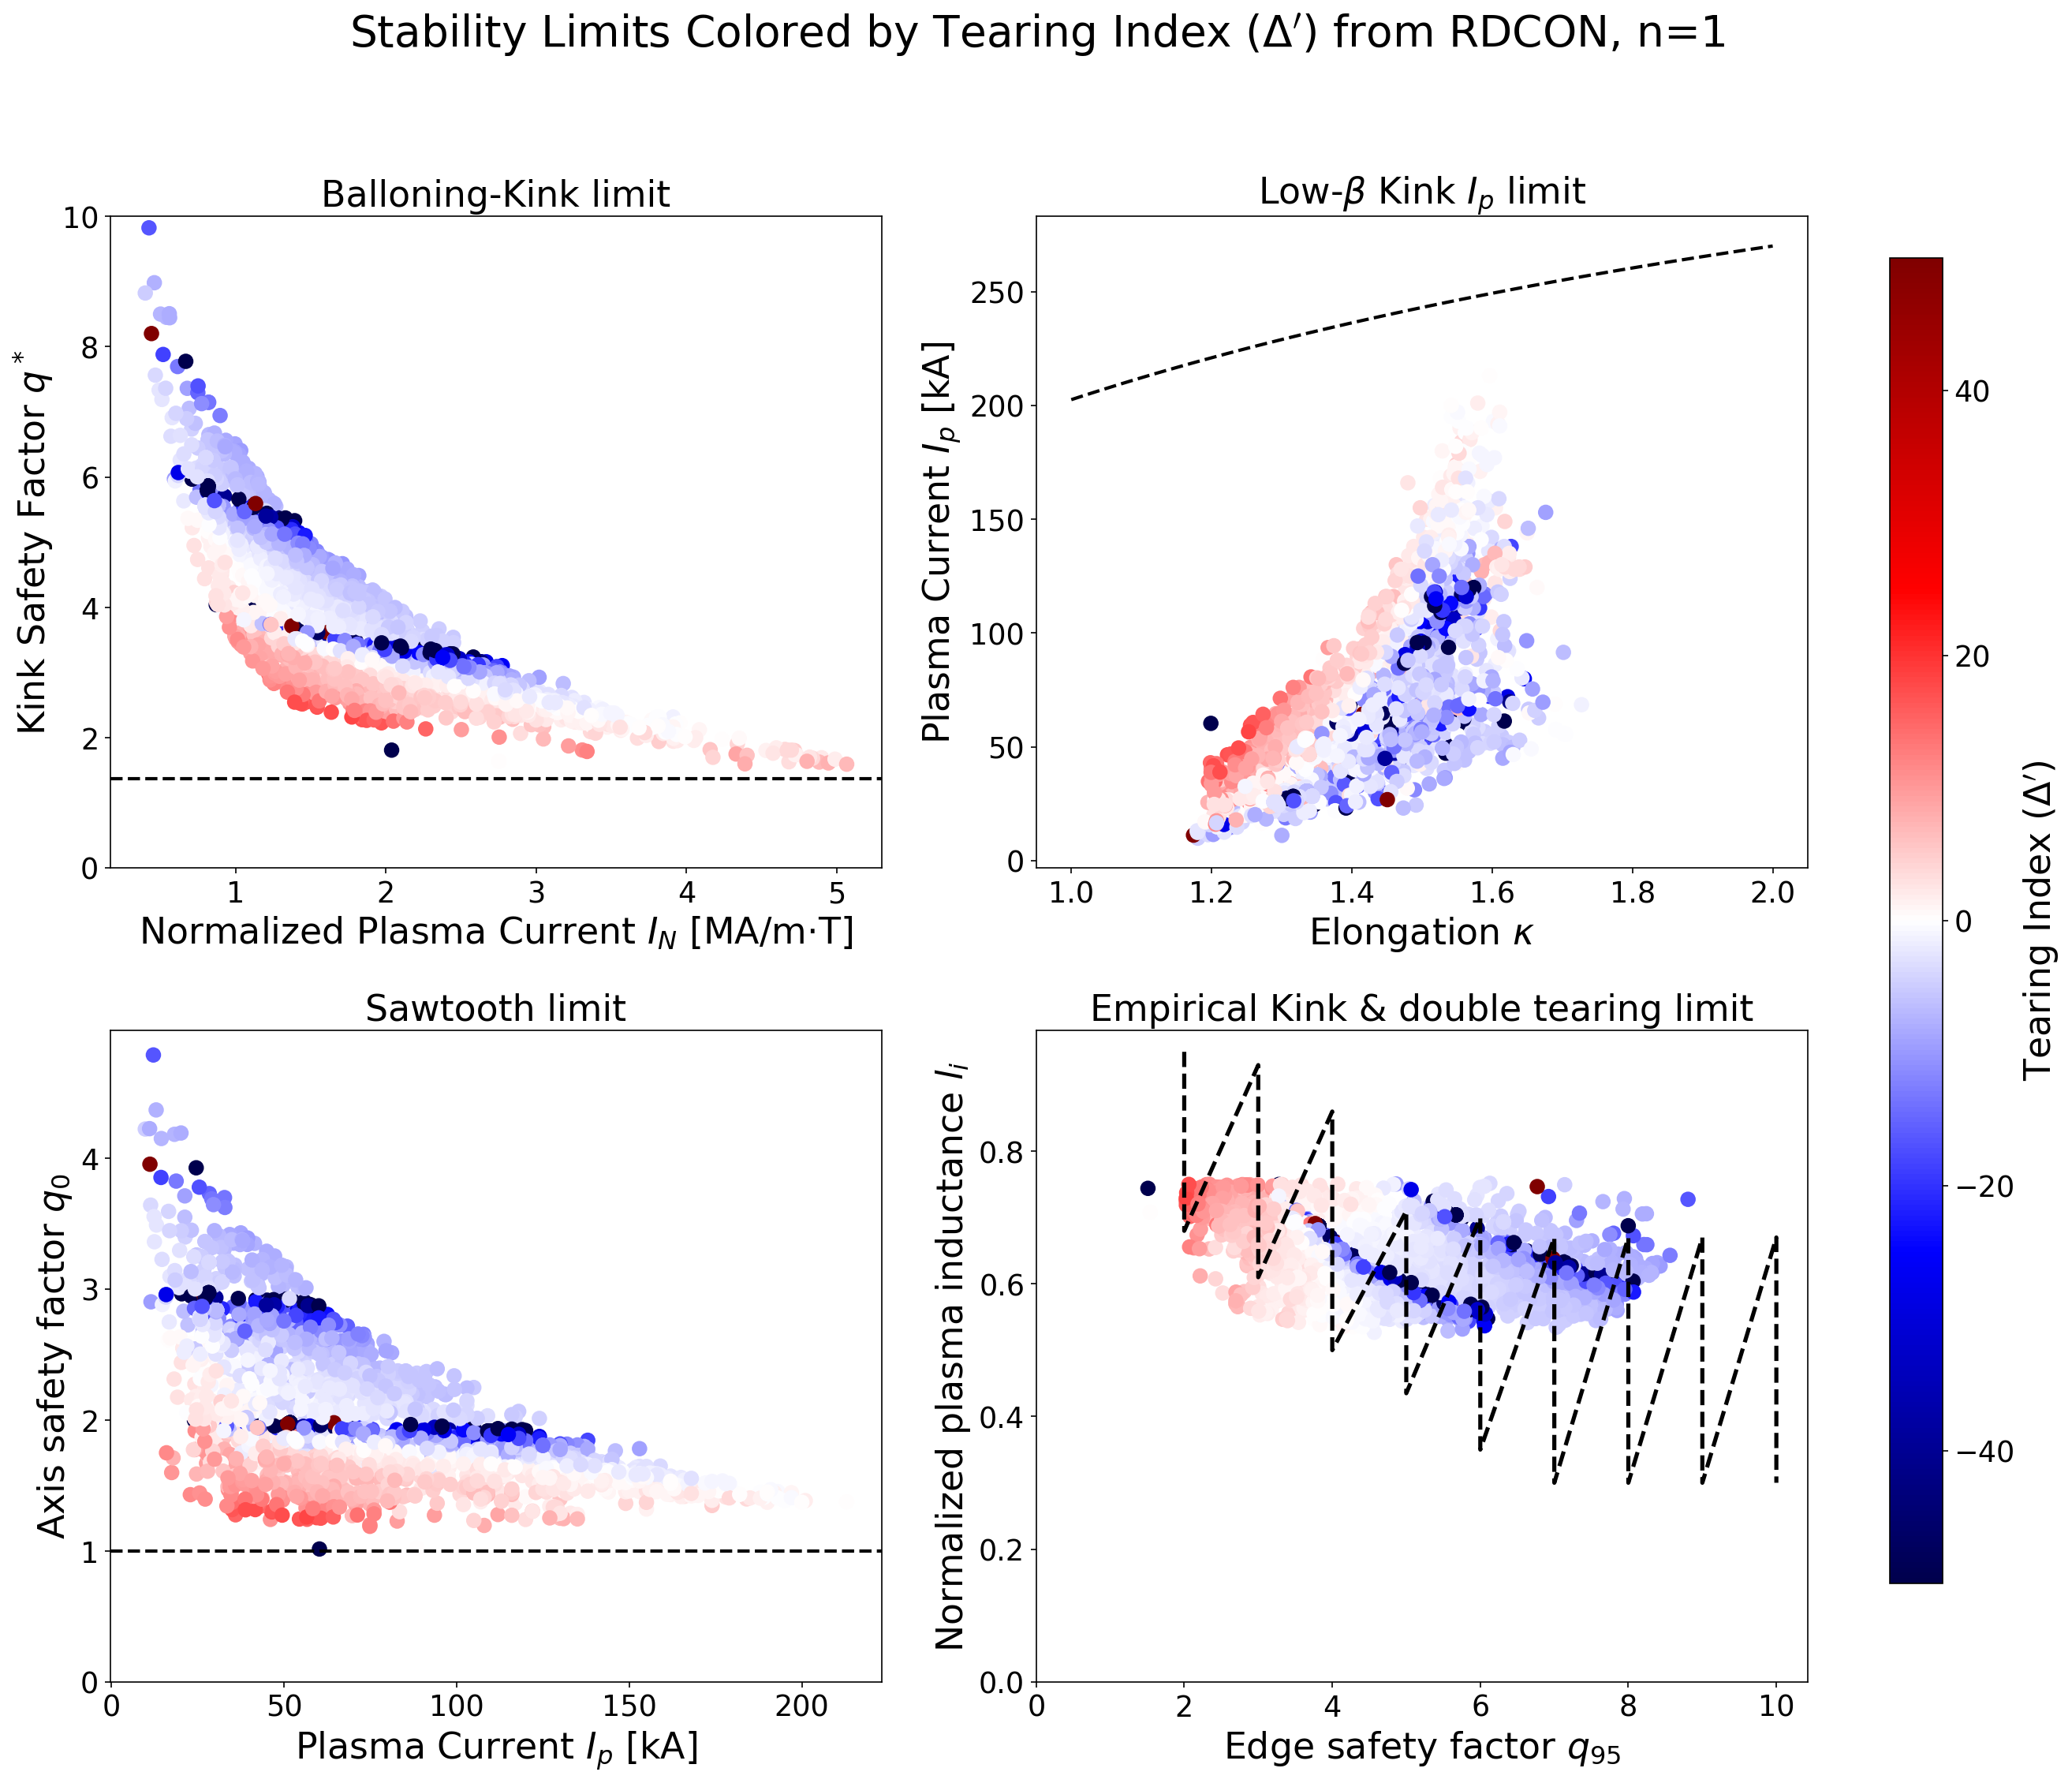

Reading data from /home/user1/h5pyd/vaft/workflow/history_data_mining/chease_dcon_history.xlsx...


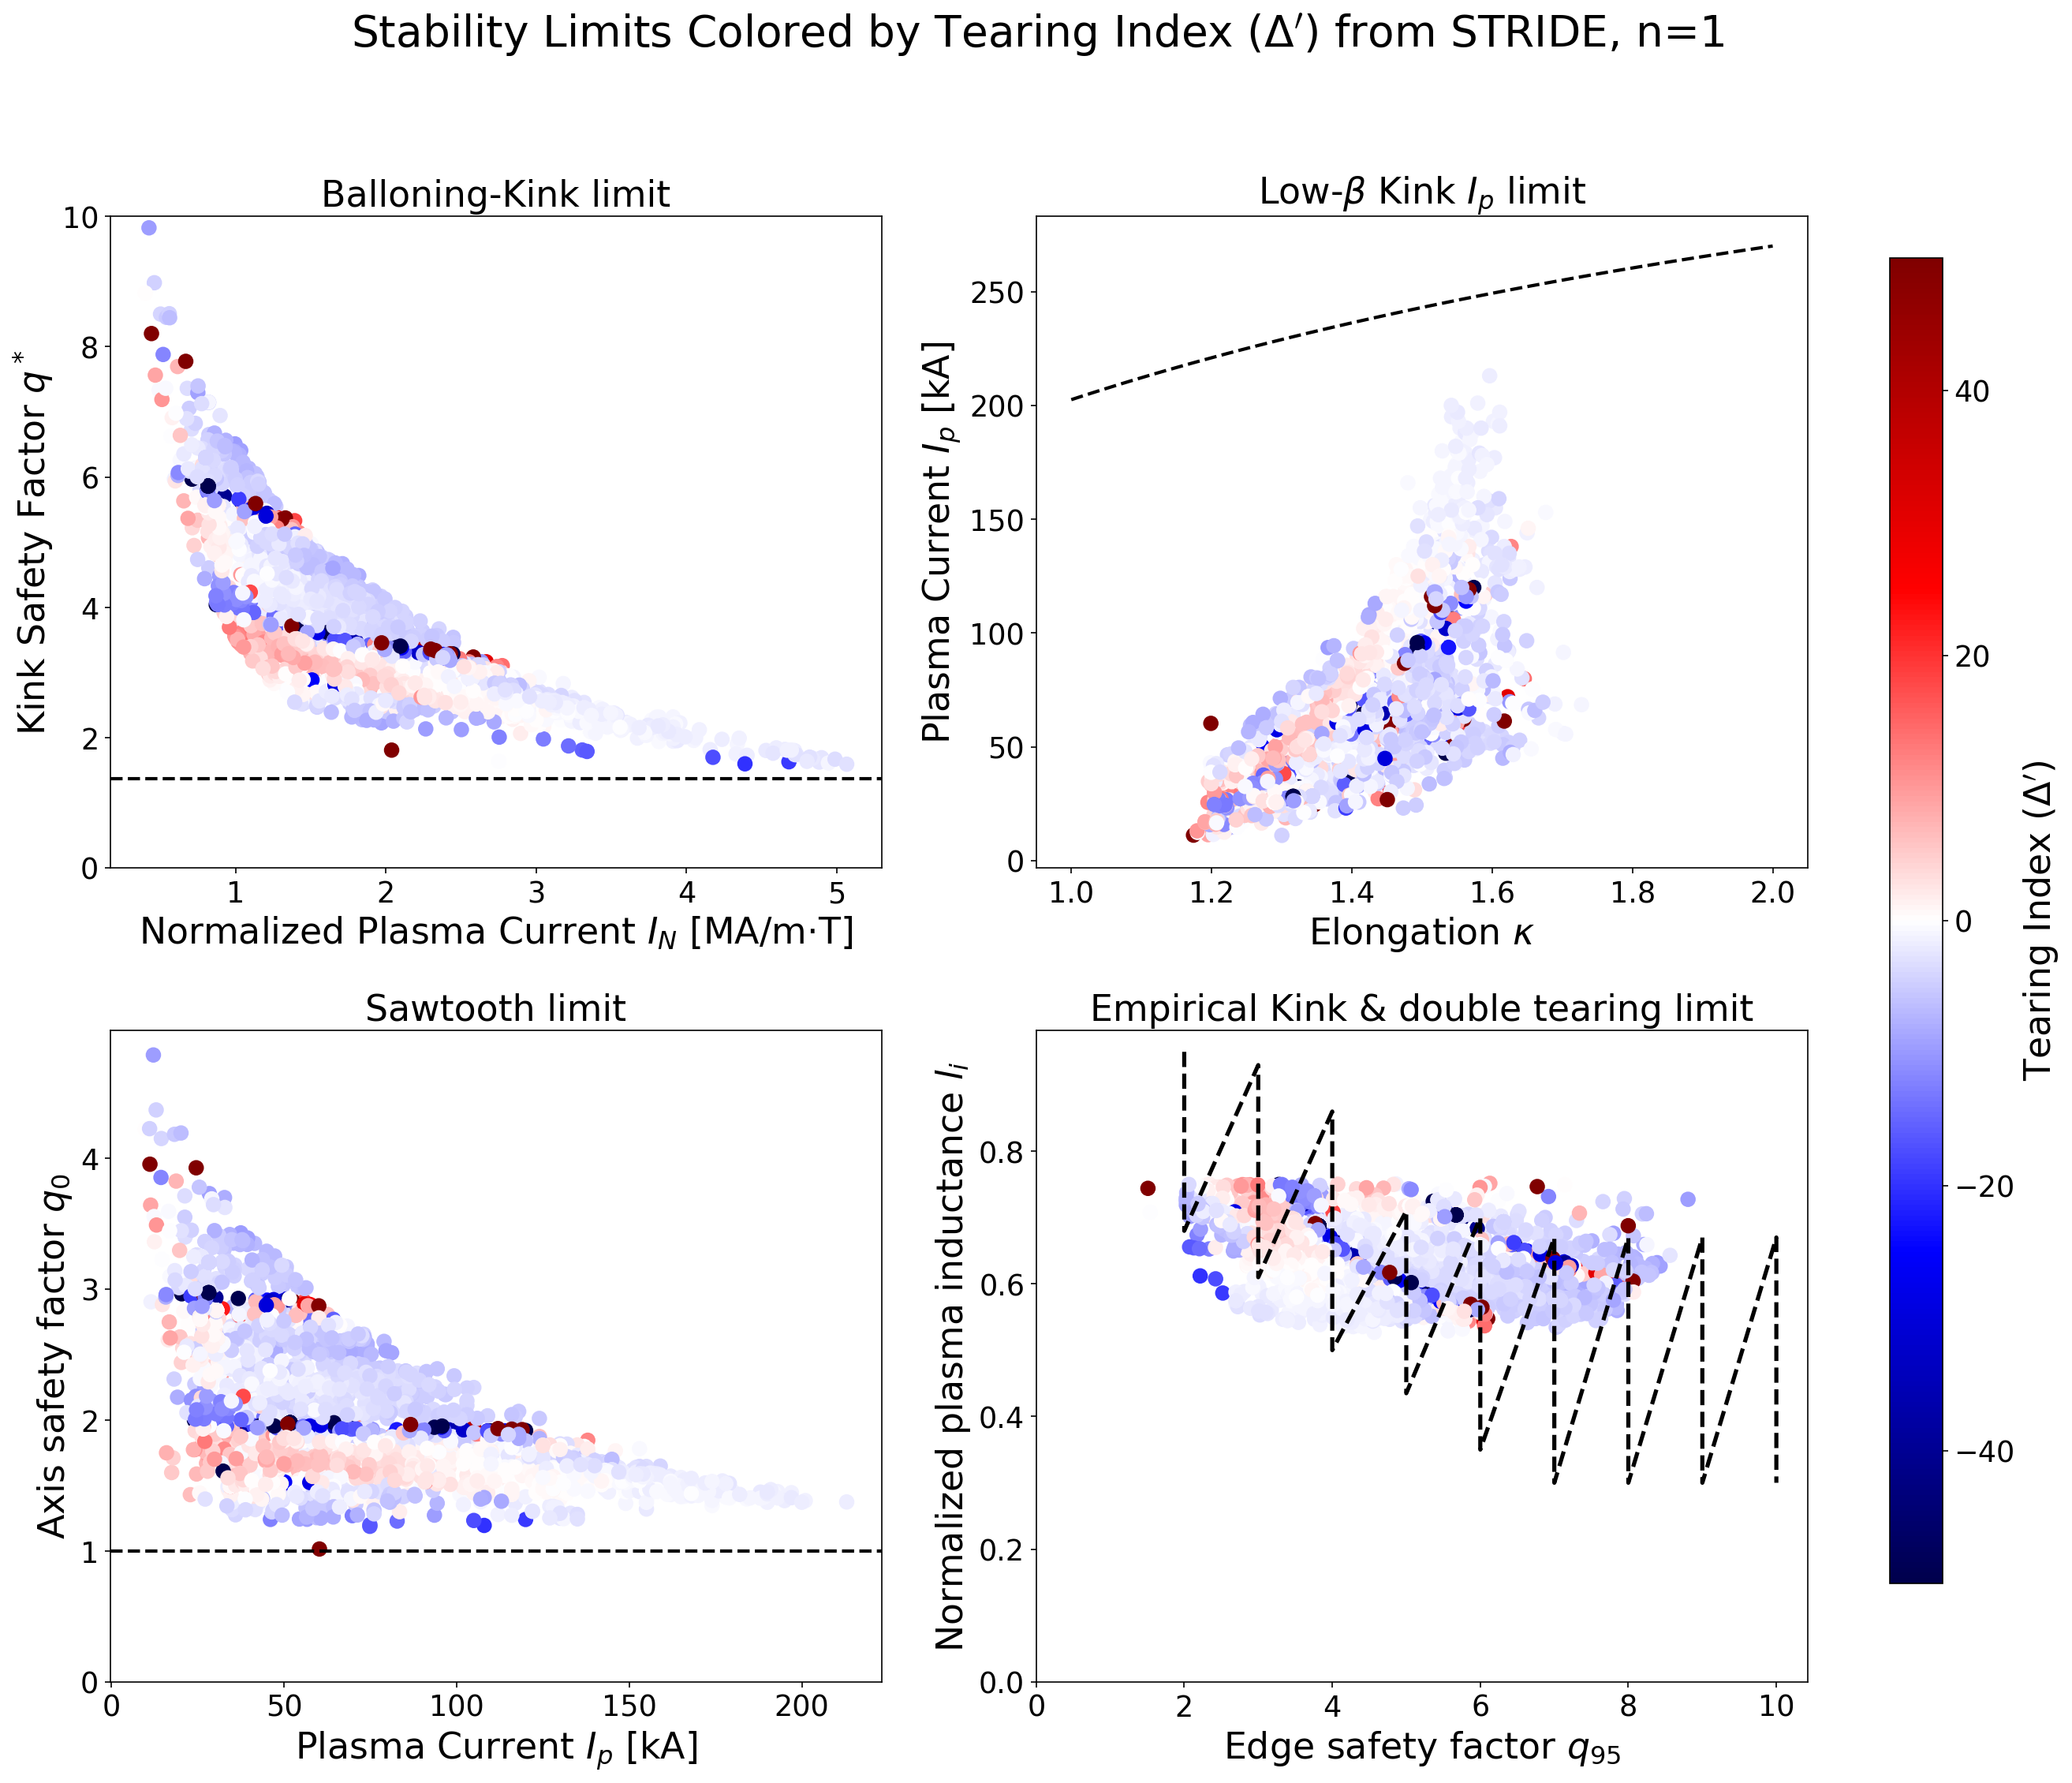

Reading data from /home/user1/h5pyd/vaft/workflow/history_data_mining/chease_dcon_history.xlsx...


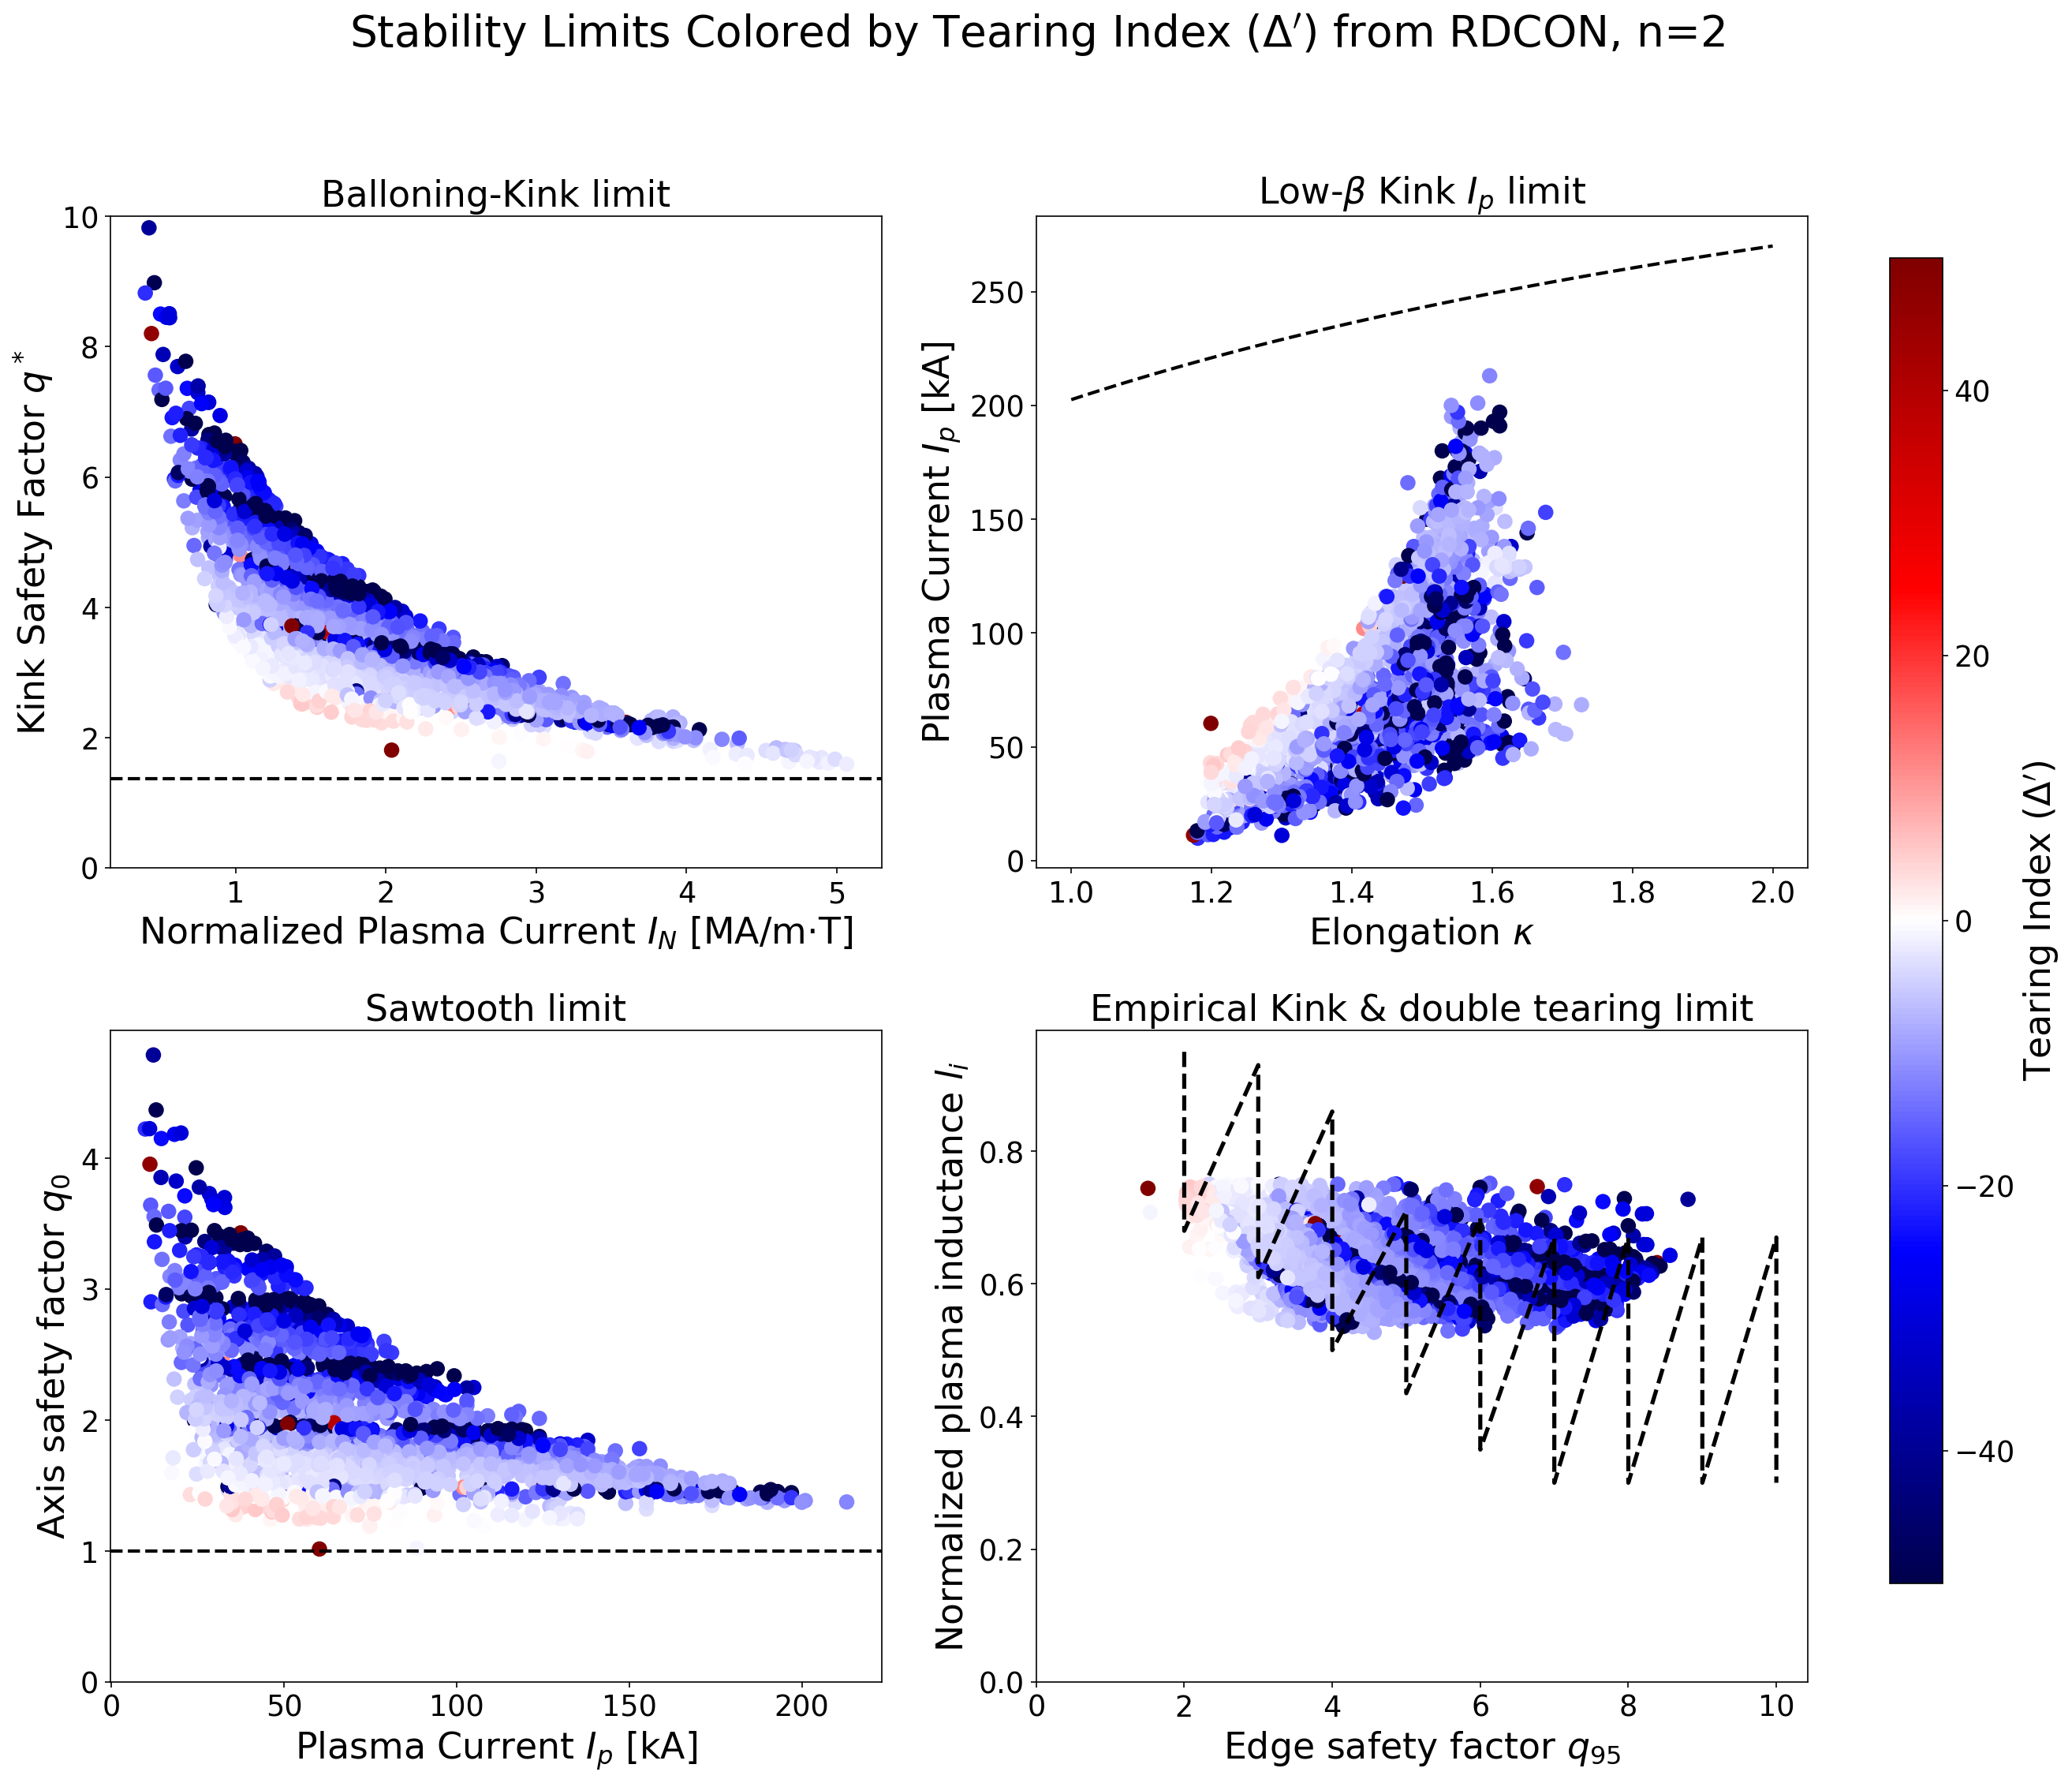

Reading data from /home/user1/h5pyd/vaft/workflow/history_data_mining/chease_dcon_history.xlsx...


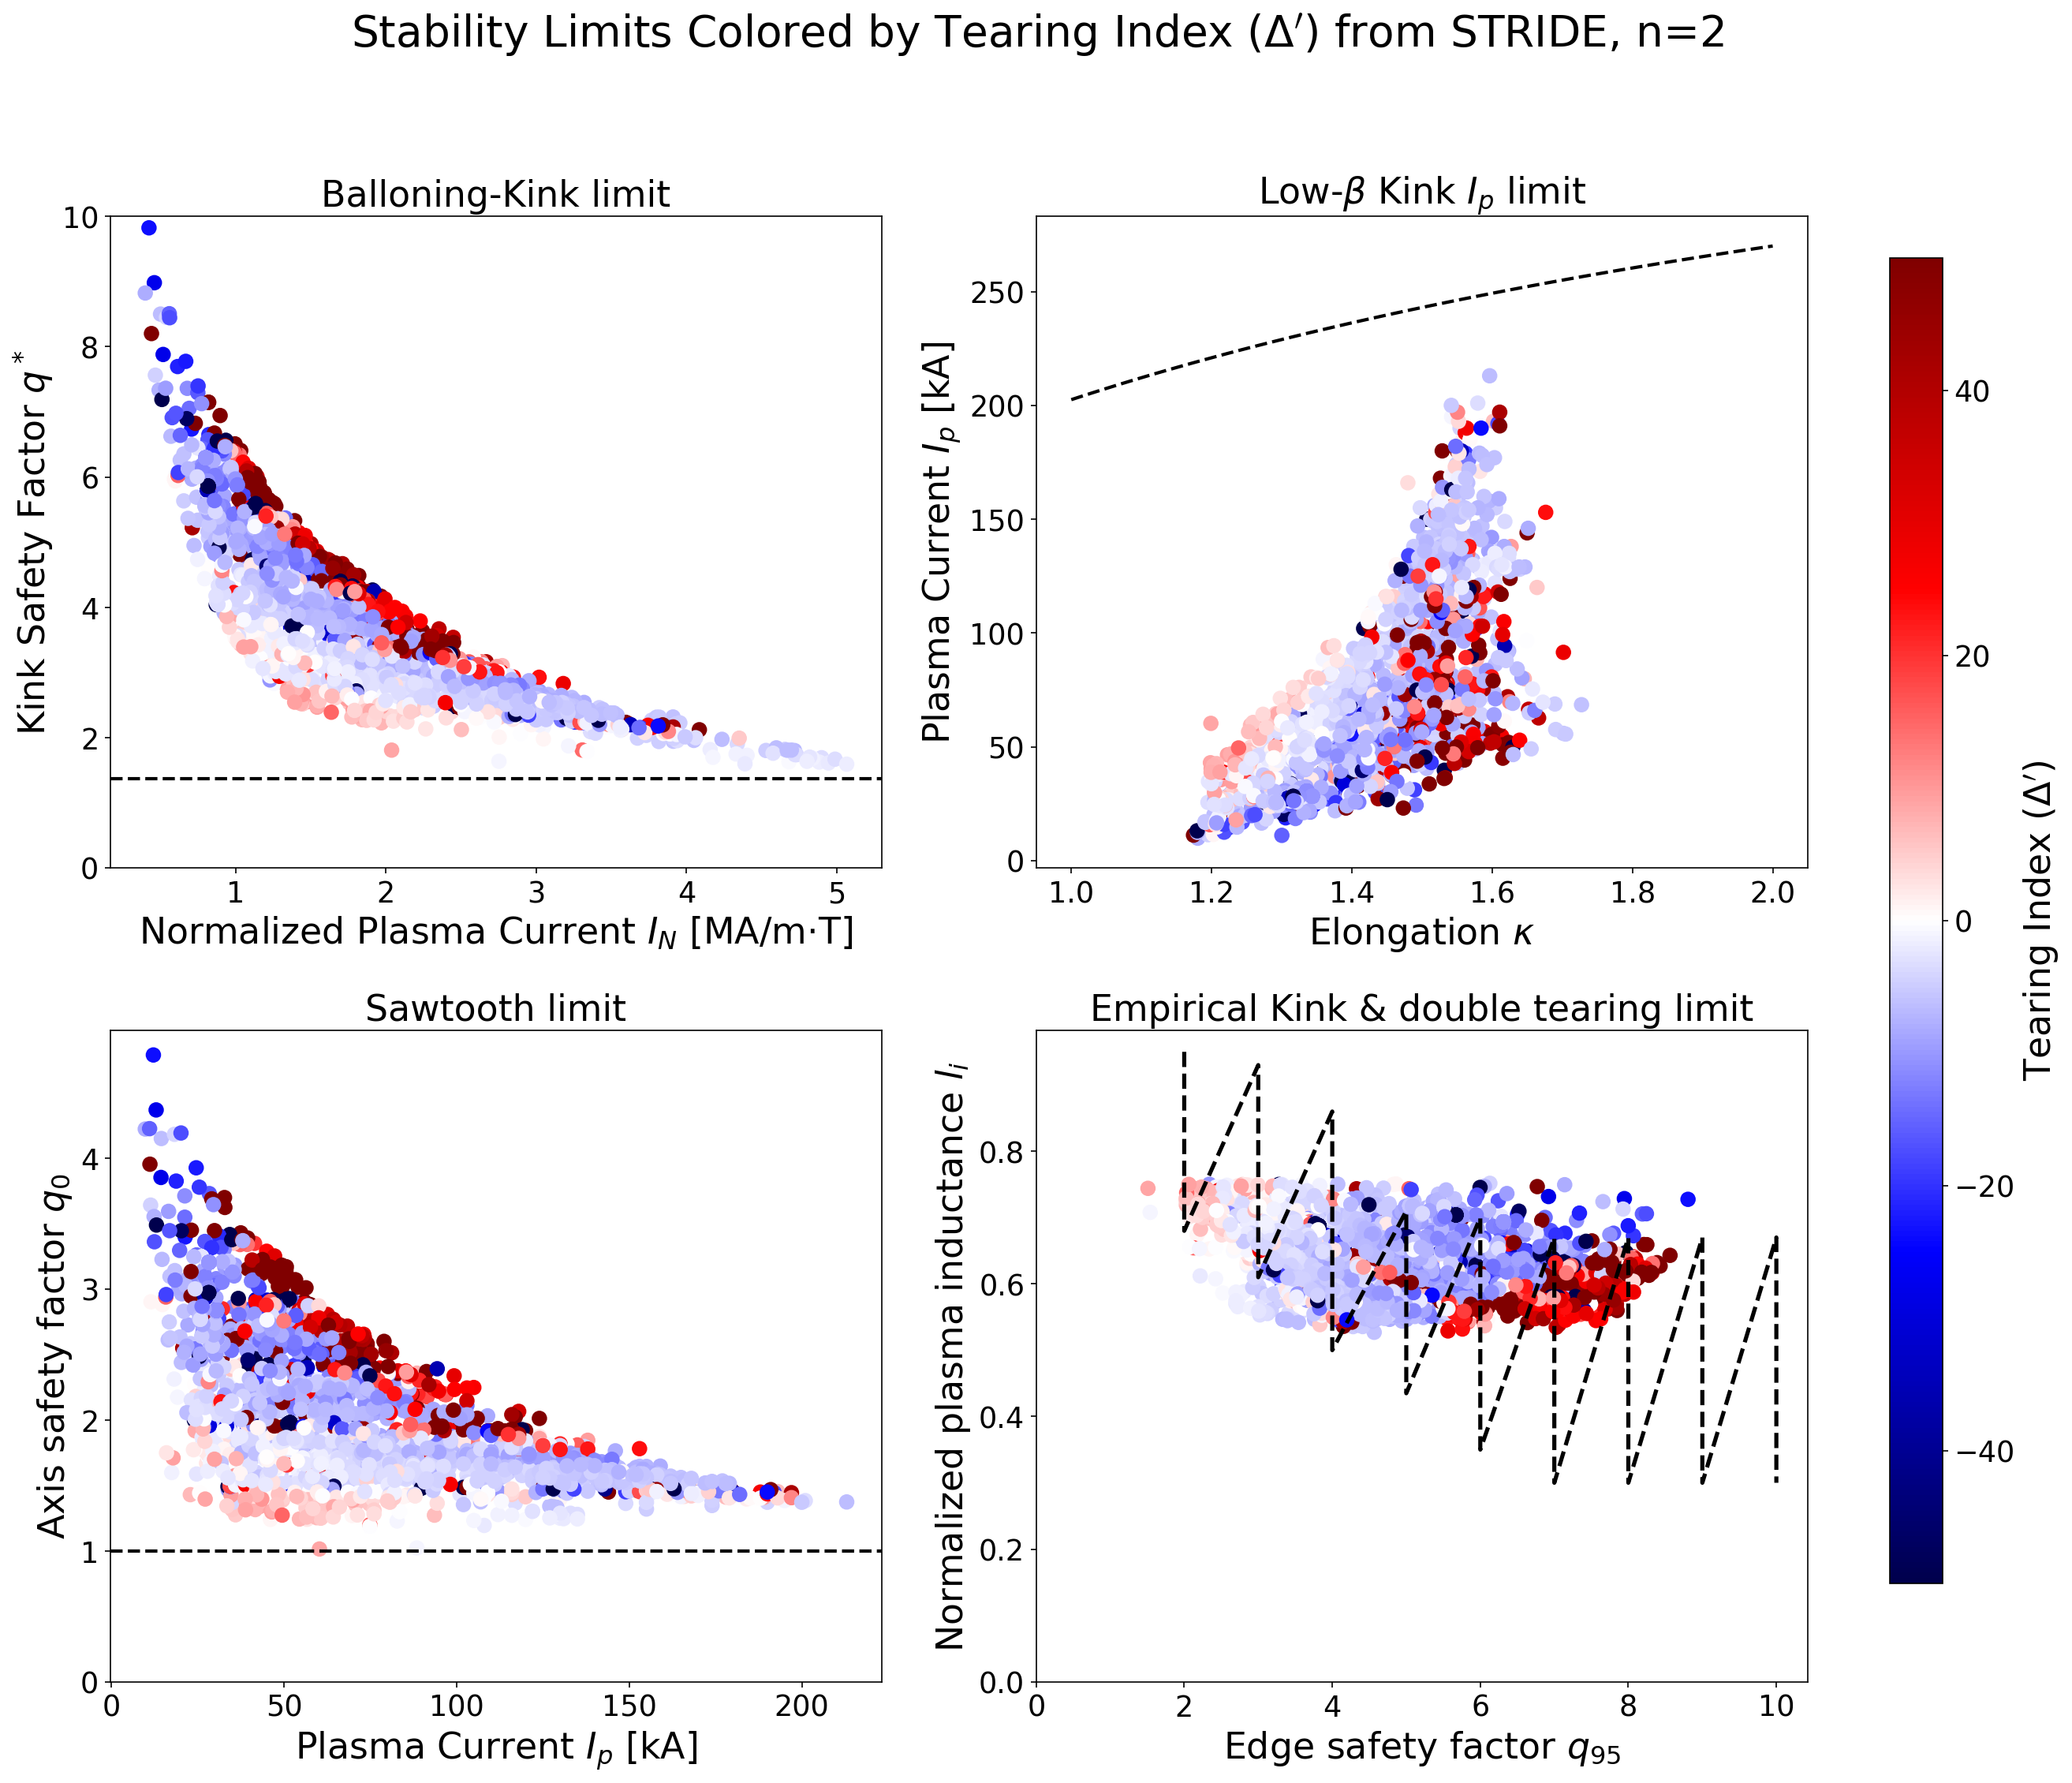

In [192]:
vmin = -50
vmax = 50
cmap = 'seismic'
plot_stability_limits_delta_prime_grid(input_file, 'rdcon', 1, vmin=-50, vmax=50, cmap='seismic')
plot_stability_limits_delta_prime_grid(input_file, 'stride', 1, vmin=-50, vmax=50, cmap='seismic')
plot_stability_limits_delta_prime_grid(input_file, 'rdcon', 2, vmin=-50, vmax=50, cmap='seismic')
plot_stability_limits_delta_prime_grid(input_file, 'stride', 2, vmin=-50, vmax=50, cmap='seismic')

In [267]:
def plot_all_pairwise_scatters(input_file="chease_dcon_history.xlsx", output_dir="corr"):
    """
    For all pairs of selected columns, plot scatter plots colored by stability
    and save them to the output directory.
    """
    columns = [
        'ip [kA]', 'major_radius [m]', 'minor_radius [m]', 'aspect_ratio',
        'elongation', 'triangularity', 'q_axis', 'q_min',
        'q95', 'magnetic_axis_r [m]', 'beta_poloidal',
        'b_field_tor_axis [T]', 'plasma_volume [m^3]', 'beta_toroidal', 'beta_normal', 'li_3'
    ]
    # Remove duplicates if any to ensure clean processing
    columns = list(dict.fromkeys(columns))
    
    try:
        df = pd.read_excel(input_file)
    except FileNotFoundError:
        print(f"Error: Input file not found at {input_file}")
        return
        
    # --- Perform Stability Classification ---
    df['stability_class'] = 'stable'
    # These column names are assumed to exist in the excel file
    n1_mask = df['tearing_index_rdcon_n1'] > 0
    n2_mask = df['tearing_index_rdcon_n2'] > 0
    ideal_mask = df['ideal_stability'] == 'Unstable'
    df.loc[ideal_mask, 'stability_class'] = 'ideal_unstable'
    df.loc[~ideal_mask & n2_mask, 'stability_class'] = 'n2_resistive_unstable'
    df.loc[~ideal_mask & ~n2_mask & n1_mask, 'stability_class'] = 'n1_resistive_unstable'

    # Define colors and titles for the legend
    colors = {
        'stable': 'green',
        'n1_resistive_unstable': 'orange',
        'n2_resistive_unstable': 'yellow',
        'ideal_unstable': 'red'
    }
    class_titles = {
        'stable': 'Stable',
        'n1_resistive_unstable': 'n=1 Resistive Unstable',
        'n2_resistive_unstable': 'n=2 Resistive Unstable',
        'ideal_unstable': 'Ideal Unstable'
    }
        
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    # Iterate through all unique combinations of 2 columns
    for var1, var2 in itertools.combinations(columns, 2):
        # Check if both columns exist in the DataFrame
        if var1 not in df.columns or var2 not in df.columns:
            print(f"Warning: Skipping pair ({var1}, {var2}) as one or both columns not found.")
            continue
            
        # Keep 'stability_class' and drop NaNs from the plotting variables
        required_cols = [var1, var2, 'stability_class']
        valid_data = df[required_cols].dropna(subset=[var1, var2])
        
        if valid_data.empty:
            print(f"Warning: Skipping pair ({var1}, {var2}) due to no valid data points.")
            continue
            
        plt.figure(figsize=(8, 7))

        # Plot each stability class with its own color
        for stability_class, title in class_titles.items():
            mask = valid_data['stability_class'] == stability_class
            if mask.any():
                plt.scatter(
                    valid_data.loc[mask, var1],
                    valid_data.loc[mask, var2],
                    alpha=0.7,
                    s=20,
                    color=colors[stability_class],
                    edgecolor='k',
                    linewidth=0.5,
                    label=title
                )

        plt.xlabel(var1)
        plt.ylabel(var2)
        plt.title(f"{var1} vs {var2}")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()
        plt.tight_layout()
        
        # Create a clean filename by replacing special characters
        clean_var1 = var1.replace(' ', '_').replace('[','').replace(']','').replace('%','').replace('/','')
        clean_var2 = var2.replace(' ', '_').replace('[','').replace(']','').replace('%','').replace('/','')
        fname = f"{output_dir}/{clean_var1}_vs_{clean_var2}.png"
        
        plt.savefig(fname, dpi=200)
        plt.close() # Close the figure to free up memory
        
    print(f"All pairwise scatter plots with stability coloring have been saved in the '{output_dir}' folder.")

plot_all_pairwise_scatters(input_file='/home/user1/h5pyd/vaft/workflow/history_data_mining/chease_dcon_history.xlsx', output_dir='corr')

All pairwise scatter plots with stability coloring have been saved in the 'corr' folder.


Figure 9. Correlation of an Observed Instability with Stability Analysis 


In [51]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from dataclasses import dataclass
import vaft 

# --- Data Structure for Results ---

@dataclass
class SpectrogramResult:
    """A structured data object for STFT results."""
    frequencies: np.ndarray
    time_bins: np.ndarray
    magnitude: np.ndarray
    shot_info: dict
    plot_config: dict

# --- Core Processing Functions ---

def design_fir_filter(sampling_rate: float, cutoff_freq, filter_type: str) -> np.ndarray:
    """Designs FIR filter coefficients using the firwin method."""
    filter_order = int(sampling_rate * 1e-3)
    if filter_order % 2 == 0:
        filter_order += 1  # Ensure odd order for Type I filter

    if filter_type not in ['lowpass', 'highpass', 'bandpass']:
        raise ValueError("Filter type must be 'lowpass', 'highpass', or 'bandpass'")

    pass_zero_mapping = {'lowpass': True, 'highpass': False, 'bandpass': False}
    return signal.firwin(
        filter_order,
        cutoff_freq,
        fs=sampling_rate,
        pass_zero=pass_zero_mapping[filter_type],
        window='hann'
    )

def load_signal(shot_config: dict) -> tuple[np.ndarray, np.ndarray]:
    """Loads raw signal data from the database."""
    shot = shot_config["shot_number"]
    field = shot_config["field_id"]
    print(f"--- Loading data for Shot #{shot} (Field: {field}) ---")
    time_raw, data_raw = vaft.database.load_raw(shot, field)
    return time_raw, data_raw

def process_signal(data_raw: np.ndarray, proc_config: dict) -> np.ndarray:
    """Filters and calibrates the raw signal."""
    fs = proc_config["sampling_rate"]
    
    b_high = design_fir_filter(fs, proc_config["high_pass_cutoff"], 'highpass')
    b_low = design_fir_filter(fs, proc_config["low_pass_cutoff"], 'lowpass')
    
    processed = data_raw - np.mean(data_raw)
    processed = signal.filtfilt(b_high, 1.0, processed)
    processed = signal.filtfilt(b_low, 1.0, processed)
    data_processed = processed / proc_config["amplifier_gain"]
    print("--- Signal processing complete ---")
    return data_processed

def analyze_signal(config: dict) -> SpectrogramResult:
    """
    Performs the full analysis pipeline: load, process, and STFT.
    Returns a structured result object.
    """
    # Load and process data
    time_raw, data_raw = load_signal(config["shot_info"])
    data_processed = process_signal(data_raw, config["processing"])
    
    # Configure STFT parameters
    fs = config["processing"]["sampling_rate"]
    window_size = config["stft"]["window_size"]
    shot_number = config["shot_info"]["shot_number"]
    time_range = config["stft"].get("time_range")
    
    # Select time range for analysis
    if time_range:
        start_idx = np.argmax(time_raw >= time_range[0])
        end_idx = np.argmax(time_raw >= time_range[1])
        xtime_indices = np.arange(start_idx, end_idx)
    else:
        if shot_number < 16566:
            xtime_indices = np.arange(len(time_raw) - window_size)
        elif shot_number < 41660:
            xtime_indices = np.arange(15000, 25000 - window_size)
        else:
            xtime_indices = np.arange(10000, 25000 - window_size)
    
    # Manual STFT implementation
    num_time_bins = len(xtime_indices)
    window_data_matrix = np.zeros((window_size, num_time_bins))
    
    half_window = window_size // 2
    for i, center_idx in enumerate(xtime_indices):
        start_slice, end_slice = center_idx - half_window, center_idx + half_window
        if start_slice >= 0 and end_slice <= len(data_processed):
            window_data_matrix[:, i] = data_processed[start_slice:end_slice]

    # Apply window function and perform FFT
    hann_window = signal.windows.hann(window_size)
    windowed_data = window_data_matrix * hann_window[:, np.newaxis]
    Y = np.fft.fft(windowed_data, axis=0)
    
    # Scale the spectrum
    P2 = np.abs(Y / window_size)
    P1 = P2[0:half_window + 1, :]
    P1[1:-1, :] *= 2

    print("--- Analysis complete ---")
    return SpectrogramResult(
        frequencies=np.fft.rfftfreq(window_size, d=1/fs),
        time_bins=time_raw[xtime_indices],
        magnitude=P1,
        shot_info=config["shot_info"],
        plot_config=config["plotting"]
    )

# --- Plotting Functions ---

def plot_spectrogram(ax: plt.Axes, result: SpectrogramResult, add_colorbar: bool = True):
    """
    Plots the spectrogram on a given Matplotlib Axes object.
    
    Args:
        ax: The Matplotlib axes to draw on.
        result: The SpectrogramResult object to plot.
        add_colorbar: If True, adds a colorbar to the axes.
    """
    plot_config = result.plot_config
    shot_info = result.shot_info
    
    t, f, Sxx_mag = result.time_bins, result.frequencies, result.magnitude
    
    # Determine color limits for linear scale
    vmax = None
    if "color_lim_max_fraction" in plot_config:
        vmax = plot_config.get("color_lim_max_fraction", 1.0) * np.max(Sxx_mag)
        
    c = ax.pcolormesh(
        t * 1000,
        f / 1e3,
        Sxx_mag,
        shading='gouraud',
        cmap=plot_config["colormap"],
        vmin=plot_config.get("color_lim_min", 0),
        vmax=vmax
    )

    if "freq_lim_khz" in plot_config:
        ax.set_ylim(plot_config["freq_lim_khz"])
    
    # ax.set_title(f'Spectrogram for Shot #{shot_info["shot_number"]} (Field: {shot_info["field_id"]})')
    ax.set_ylabel('Frequency [kHz]')
    
    if add_colorbar:
        fig = ax.get_figure()
        fig.colorbar(c, ax=ax, label='Magnitude (a.u.)')



In [ ]:
import vaft 

--- Loading data for Shot #41670 (Field: 192) ---
--- Signal processing complete ---
--- Analysis complete ---
--- Loading data for Shot #41670 (Field: 171) ---
--- Signal processing complete ---
--- Analysis complete ---


AttributeError: 'numpy.ndarray' object has no attribute 'set_xlabel'

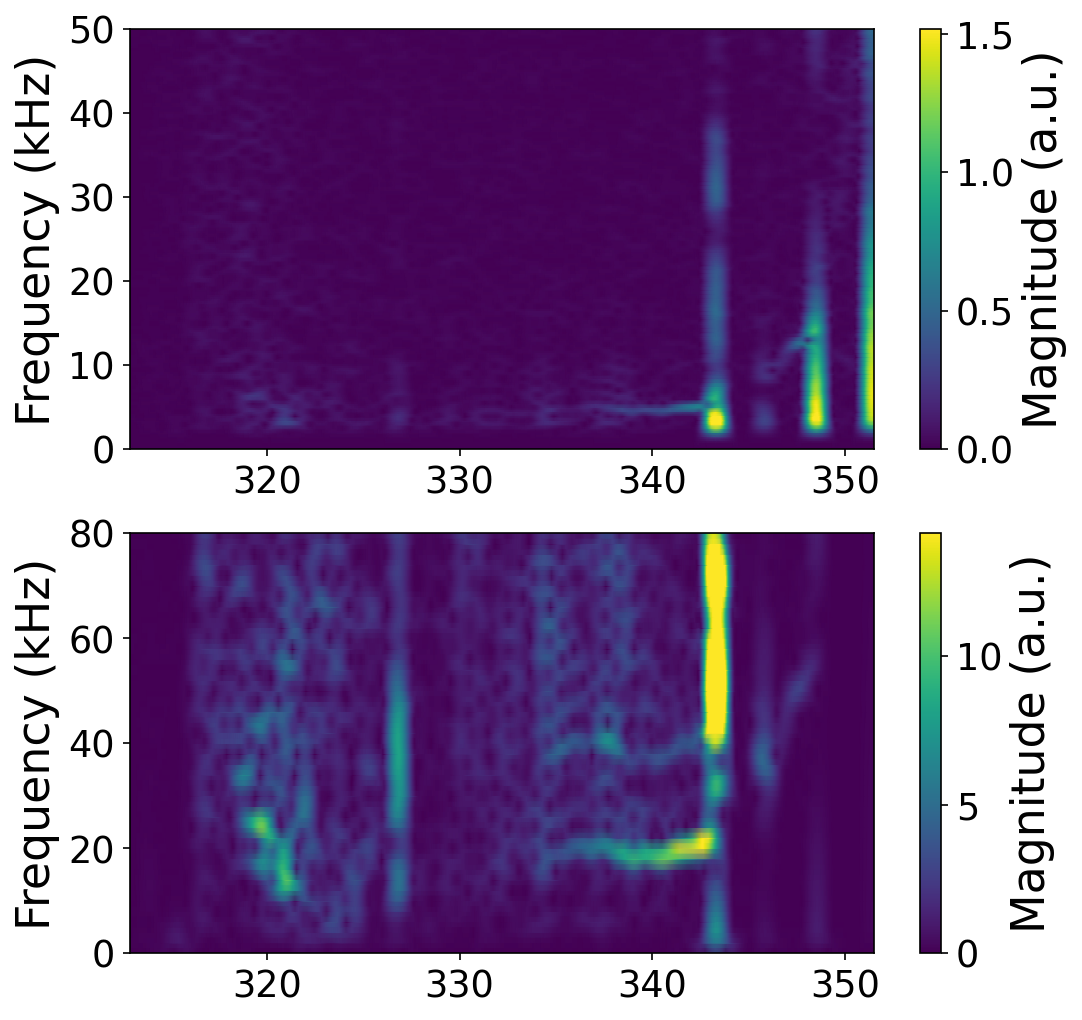

In [75]:
# 1. config 설정

shot = 41670

ods = vaft.omas.load_omas_json(f'/srv/vest.filedb/public/{shot}/omas/{shot}_diagnostics.json')

onset = vaft.omas.find_breakdown_onset(ods)
pulse_duration = vaft.omas.find_pulse_duration(ods)
offset = onset + pulse_duration
# 2. 분석 실행
inboard_result = analyze_signal(inboard_config)
outboard_result = analyze_signal(outboard_config)

# 3. 플롯
fig, ax = plt.subplots(2, 1, figsize=(8, 8))


plot_spectrogram(ax[0], inboard_result, add_colorbar=True)
plot_spectrogram(ax[1], outboard_result, add_colorbar=True)
ax.set_xlabel('Time (ms)')
plt.tight_layout()
plt.show()

In [1]:
def plot_operation_stability_analysis(shot, excel_path, save_path=None):

    # make ip / Ha / Inboard Mirnov / Outboard Mirnov / q0, qa / \delta W of n=1 ~ n=6 / \Delta^\Prime of n=1 ~ n=2
    # make 7x1 figure with 7 subplots and no tiledwidth

    # load ods
    ods = vaft.omas.load_omas_json(f'/srv/vest.filedb/public/{shot}/omas/{shot}_diagnostics.json')

    # load excel
    df = pd.read_excel(excel_path)

    # make figure
    fig, axs = plt.subplots(7, 1, figsize=(10, 15), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1, 1, 1, 1, 1]})
    plt.subplots_adjust(hspace=0.0)

    # make xlim
    ha_time = ods[f'spectrometer_uv.time'] * 1000
    channel = 0
    line_idx = 0 
    ha_data = ods[f'spectrometer_uv.channel.{channel}.processed_line.{line_idx}.intensity.data']

    (onset, offset) = vaft.process.signal_onoffset(ha_time, ha_data, smooth_window=10)
    xlim = [onset, offset] 

    # plot ip
    ip = ods['magnetics.ip.0.data'] / 1000
    ip_time = ods['magnetics.ip.0.time'] * 1000

    axs[0].plot(ip_time, ip, color='black')
    axs[0].set_ylabel('$I_p$ [kA]')
    axs[0].set_xlim(xlim)

    # plot Ha
    ha_time = ods[f'spectrometer_uv.time'] * 1000
    channel = 0
    line_idx = 0 
    ha_data = ods[f'spectrometer_uv.channel.{channel}.processed_line.{line_idx}.intensity.data']
    axs[1].plot(ha_time, ha_data, color='black')
    axs[1].set_ylabel('$H_a$ [A.U]')
    # remove yticklabel
    axs[1].set_yticklabels([])

    # anayse signal and plot spectrogram based on the config
    outboard_config = {
        "shot_info": {
            "shot_number": shot,         # 분석할 샷 번호
            "field_id": 171,          # 신호 필드명
        },
        "processing": {
            "sampling_rate": 1e6,         # 샘플링 레이트 (Hz)
            "high_pass_cutoff": 2e3,
            "low_pass_cutoff": 90e3,
            "amplifier_gain": -0.004528986,       # 증폭기 이득
        },
        "stft": {
            "window_size": 500,          # STFT 윈도우 크기
            "time_range": [onset/1000, offset/1000], # (선택) 분석할 시간 범위 (초)
        },
        "plotting": {
            "colormap": "viridis",        # 컬러맵
            "color_lim_min": 0,           # 컬러바 최소값
            "color_lim_max_fraction": 0.5,# 최대값(최대의 80%)
            "freq_lim_khz": [0, 80],      # y축(주파수) 범위 [kHz]
        }
    }

    inboard_config = {
        "shot_info": {
            "shot_number": shot,         # 분석할 샷 번호
            "field_id": 192,          # 신호 필드명
        },
        "processing": {
            "sampling_rate": 250e3,
            "high_pass_cutoff": 2e3,
            "low_pass_cutoff": 90e3,
            "amplifier_gain": -0.05
        },
        "stft": {
            "window_size": 500,          # STFT 윈도우 크기
            "time_range": [onset/1000, offset/1000], # (선택) 분석할 시간 범위 (초)
        },
        "plotting": {
            "colormap": "viridis",        # 컬러맵
            "color_lim_min": 0,           # 컬러바 최소값
            "color_lim_max_fraction": 0.8,# 최대값(최대의 80%)
            "freq_lim_khz": [0, 80],      # y축(주파수) 범위 [kHz]
        }
    }


    outboard_result = analyze_signal(outboard_config)
    inboard_result = analyze_signal(inboard_config)

    # plot spectrogram
    plot_spectrogram(axs[2], outboard_result, add_colorbar=False)
    # get ylabel fontsize and reduce ylabel fontsize * 0.8
    ylabel_fontsize = axs[2].yaxis.label.get_fontsize()
    axs[2].set_ylabel('Outboard\nMirnov [kHz]', fontsize=ylabel_fontsize * 0.8)
    plot_spectrogram(axs[3], inboard_result, add_colorbar=False)
    axs[3].set_ylabel('Inboard\nMirnov [kHz]', fontsize=ylabel_fontsize * 0.8)

    # extract shotdata from df 
    shot_data = df[df['shot'] == shot]

    # plot time series of q0, qa as .-
    axs[4].plot(shot_data['time [ms]'], shot_data['qlim'], label='$q_{a}$', marker='o')
    axs[4].plot(shot_data['time [ms]'], shot_data['q_axis'], label='$q_{0}$', marker='o')
    axs[4].set_ylabel('$q$')
    # make grid 
    axs[4].grid(True)
    ymax = 10 
    ymin = 0
    # ytics 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
    axs[4].set_yticks([2, 4, 6, 8, 10])
    axs[4].set_ylim(ymin, ymax)
    axs[4].legend(loc='upper left')

    # plot time series of \delta W of n=1 ~ n=6 as o- stiye
    axs[5].plot(shot_data['time [ms]'], shot_data['delta_w_n1'], label='n=1', marker='o')
    axs[5].plot(shot_data['time [ms]'], shot_data['delta_w_n2'], label='n=2', marker='o')
    axs[5].plot(shot_data['time [ms]'], shot_data['delta_w_n3'], label='n=3', marker='o')
    axs[5].plot(shot_data['time [ms]'], shot_data['delta_w_n4'], label='n=4', marker='o')
    axs[5].plot(shot_data['time [ms]'], shot_data['delta_w_n5'], label='n=5', marker='o')
    axs[5].plot(shot_data['time [ms]'], shot_data['delta_w_n6'], label='n=6', marker='o')
    # add y=0 line
    axs[5].axhline(0, color='black', linewidth=1, linestyle='--')
    axs[5].set_ylabel('$\delta W$')
    
    axs[5].legend(ncol=2)

    # plot time series of \Delta^\Prime of n=1 ~ n=2
    axs[6].plot(shot_data['time [ms]'], shot_data['tearing_index_rdcon_n1'], label='n=1', marker='o')
    axs[6].plot(shot_data['time [ms]'], shot_data['tearing_index_rdcon_n2'], label='n=2', marker='o')
    axs[6].set_ylabel('$\Delta^\prime$')
    # add y=0 line
    axs[6].axhline(0, color='black', linewidth=1, linestyle='--')
    axs[6].set_xlim(xlim)
    axs[6].legend()
    axs[6].set_xlabel('Time [ms]')

    # show
    from matplotlib.ticker import FuncFormatter

    
    xticks = np.arange(0, 25, 5)
    axs[6].set_xticks(xticks + onset)

    # 레이블은 shift되어 보이게
    axs[6].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x - onset:.0f}'))


    plt.show()

shot = 43009
excel_path = '/home/user1/h5pyd/vaft/workflow/history_data_mining/chease_stability_history.xlsx'
# save_path = '/home/user1/h5pyd/vaft/notebooks/publication_figures/41670.png'
plot_operation_stability_analysis(shot, excel_path)


<>:127: SyntaxWarning: invalid escape sequence '\d'
<>:134: SyntaxWarning: invalid escape sequence '\D'
<>:127: SyntaxWarning: invalid escape sequence '\d'
<>:134: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_3501907/1415575827.py:127: SyntaxWarning: invalid escape sequence '\d'
  axs[5].set_ylabel('$\delta W$')
/tmp/ipykernel_3501907/1415575827.py:134: SyntaxWarning: invalid escape sequence '\D'
  axs[6].set_ylabel('$\Delta^\prime$')
/tmp/ipykernel_3501907/1415575827.py:127: SyntaxWarning: invalid escape sequence '\d'
  axs[5].set_ylabel('$\delta W$')
/tmp/ipykernel_3501907/1415575827.py:134: SyntaxWarning: invalid escape sequence '\D'
  axs[6].set_ylabel('$\Delta^\prime$')


NameError: name 'vaft' is not defined

In [101]:

# find the shot number that has unstable (ideal_stability='Unstable') 


df = pd.read_excel("/home/user1/h5pyd/vaft/workflow/history_data_mining/chease_dcon_history.xlsx")

ideal_unstable_shots_unfiltered = df[df['ideal_stability'] == 'Unstable']['shot'].values
ideal_unstable_shots = []
for shot in ideal_unstable_shots_unfiltered:
    # check number of rows is more than 5
    if len(df[df['shot'] == shot]) > 5:
        if len(df[df['shot'] == shot]) < 15:
            ideal_unstable_shots.append(shot)

# make column 'n1_resistive_unstable' based on 'tearing_index_rdcon_n1'
df['n1_resistive_unstable'] = df['tearing_index_rdcon_n1'] > 0

# make column 'n2_resistive_unstable' based on 'tearing_index_rdcon_n2'
df['n2_resistive_unstable'] = df['tearing_index_rdcon_n2'] > 0

n1_resistive_unstable_shots = []
n1_resistive_unstable_shots_unfiltered = df[df['n1_resistive_unstable'] == True]['shot'].values
for shot in n1_resistive_unstable_shots_unfiltered:
    if len(df[df['shot'] == shot]) > 8:
        if len(df[df['shot'] == shot]) < 15:
            n1_resistive_unstable_shots.append(shot)

n2_resistive_unstable_shots = []
n2_resistive_unstable_shots_unfiltered = df[df['n2_resistive_unstable'] == True]['shot'].values
for shot in n2_resistive_unstable_shots_unfiltered:
    if len(df[df['shot'] == shot]) > 5:
        if len(df[df['shot'] == shot]) < 15:
            n2_resistive_unstable_shots.append(shot)

ideal_unstable_shots = list(set(ideal_unstable_shots))
n1_resistive_unstable_shots = list(set(n1_resistive_unstable_shots))
n2_resistive_unstable_shots = list(set(n2_resistive_unstable_shots))

print('ideal unstable shots: ', len(ideal_unstable_shots))
print('n1_resistive_unstable shots: ', len(n1_resistive_unstable_shots))
print('n2_resistive_unstable shots: ', len(n2_resistive_unstable_shots))

ideal unstable shots:  15
n1_resistive_unstable shots:  12
n2_resistive_unstable shots:  12


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from omas import ODS
from vaft.omas import odc_or_ods_check
import vaft
# addpathc of vfit_tools
import sys
sys.path.append('/home/user1/test/laurent/VEST_database/OMAS/')
from VFIT_tools import vfit_vac1

shot = 41670
ods_dia = vaft.omas.load_omas_json(f'/srv/vest.filedb/public/{shot}/omas/{shot}_diagnostics.json')
ods_eddy = vaft.omas.load_omas_json(f'/srv/vest.filedb/public/{shot}/omas/{shot}_eddy.json')
# ods_chease = vaft.omas.load_omas_json(f'/srv/vest.filedb/public/{shot}/omas/{shot}_chease.json')

ods = ODS()
ods.update(ods_dia)
ods.update(ods_eddy)
# ods.update(ods_chease)

(vacuum_time, vacuum_psi, vacuum_br, vacuum_bz) = vfit_vac1(ods,[(0.4, 0.0)] )


vacuum_psi = vacuum_psi[0]
vacuum_br = vacuum_br[0]
vacuum_bz = vacuum_bz[0]



Iw calculation:
0.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0


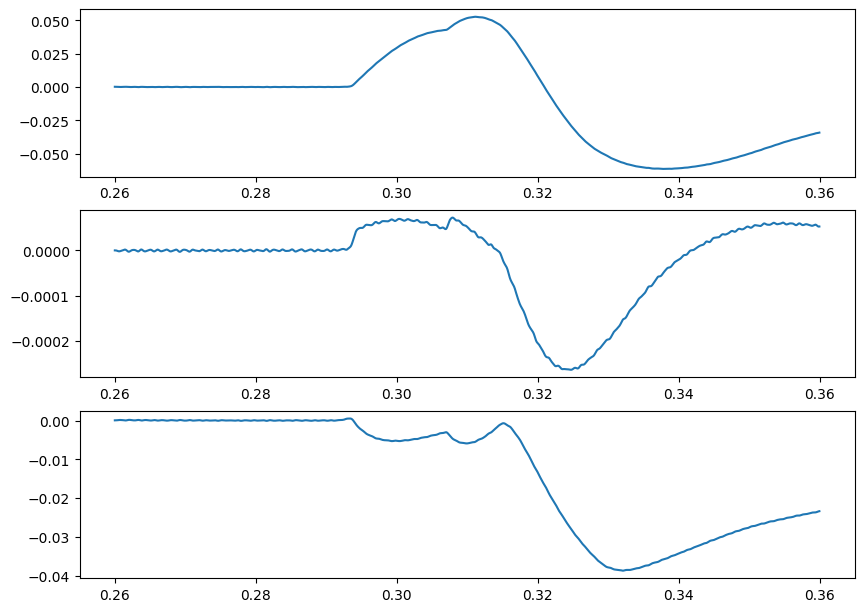

In [10]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(vacuum_time, vacuum_psi[0])
plt.subplot(4, 1, 2)
plt.plot(vacuum_time, vacuum_br[0])
plt.subplot(4, 1, 3)
plt.plot(vacuum_time, vacuum_bz[0])
plt.show()


In [71]:
IDEAL_SAVE_PATH = '/home/user1/h5pyd/vaft/notebooks/ideal_unstable/'
N1_RESISTIVE_SAVE_PATH = '/home/user1/h5pyd/vaft/notebooks/n1_resistive_unstable/'
N2_RESISTIVE_SAVE_PATH = '/home/user1/h5pyd/vaft/notebooks/n2_resistive_unstable/'
EXCEL_FILE_PATH = '/home/user1/h5pyd/vaft/workflow/history_data_mining/chease_stability_history.xlsx'

# make directory if not exist
if not os.path.exists(IDEAL_SAVE_PATH):
    os.makedirs(IDEAL_SAVE_PATH)
if not os.path.exists(N1_RESISTIVE_SAVE_PATH):
    os.makedirs(N1_RESISTIVE_SAVE_PATH)
if not os.path.exists(N2_RESISTIVE_SAVE_PATH):
    os.makedirs(N2_RESISTIVE_SAVE_PATH)

for i in range(len(ideal_unstable_shots)):
    plot_operation_stability_analysis(shot=ideal_unstable_shots[i], excel_path=EXCEL_FILE_PATH, save_path=IDEAL_SAVE_PATH)

for i in range(len(n1_resistive_unstable_shots)):
    plot_operation_stability_analysis(shot=n1_resistive_unstable_shots[i], excel_path=EXCEL_FILE_PATH, save_path=N1_RESISTIVE_SAVE_PATH)

for i in range(len(n2_resistive_unstable_shots)):
    plot_operation_stability_analysis(shot=n2_resistive_unstable_shots[i], excel_path=EXCEL_FILE_PATH, save_path=N2_RESISTIVE_SAVE_PATH)

NameError: name 'ideal_unstable_shots' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from omas import ODS
from vaft.omas import odc_or_ods_check
import vaft
# addpathc of vfit_tools
import sys
sys.path.append('/home/user1/test/laurent/VEST_database/OMAS/')
from VFIT_tools import vfit_vac1



def handle_xlim(odc_or_ods, xlim_param='plasma'):
    """Helper function to handle xlim logic."""
    odc = odc_or_ods_check(odc_or_ods)
    if xlim_param == 'none':
        return None
    elif xlim_param == 'plasma':
        return set_xlim_time(odc, type='plasma')
    elif xlim_param == 'coil':
        return set_xlim_time(odc, type='coil')
    elif isinstance(xlim_param, list) and len(xlim_param) == 2:
        return xlim_param
    else:
        print(f"Invalid xlim: {xlim_param}, using default 'plasma'")
        return set_xlim_time(odc, type='plasma')

def time_equilibrium_analysis(ods, xunit='s', xlim='plasma'):
    """
    Generate a 7x1 analysis plot of key plasma parameters.

    This plot provides a comprehensive overview of the discharge with a single
    vertical column, showing the time evolution of:
    Ip, Vloop, Bz, R, Elongation, Delta, and BetaN.

    Args:
        ods (ODS): Input data object from the omas library.
        xunit (str): Time unit for the x-axis ('s' or 'ms'). Default is 's'.
        xlim (str or list): X-axis limits setting. Can be 'plasma', 'coil', 'none',
                            or a list of two floats. Default is 'plasma'.
    """
    xlim_processed = handle_xlim(ods, xlim)
    
    # 가상 데이터 포인트 (0.4, 0.0)에서의 진공 필드 계산
    # 실제 환경에 맞게 좌표를 수정해야 할 수 있습니다.
    # vacuum_time, vacuum_vloop, _, vacuum_bz = compute_point_vacuum_fields_ods(ods, [(0.4, 0.0)], mode='vacuum')
    vacuum_time, vacuum_psi, _, vacuum_bz = vfit_vac1(ods, [(0.4, 0.0)])
    vacuum_psi = vacuum_psi[0]
    vacuum_bz = vacuum_bz[0]

    # cal vacuum_vloop = -d(psi)/dt
    vacuum_vloop = - np.gradient(vacuum_psi, vacuum_time)


    # 7x1 레이아웃으로 변경
    fig, axs = plt.subplots(
        7, 1,
        figsize=(8, 16),  # 7x1 레이아웃에 맞게 크기 조정
        dpi=150,
        sharex=True,
        gridspec_kw={'hspace': 0.1} # 서브플롯 간의 수직 간격 조정
    )

    fig.subplots_adjust(
        left=0.15, right=0.9,
        top=0.95, bottom=0.08
    )

    PLOT_STYLES = {
        'diagnostic': dict(color='black', linestyle='-'),
        'vacuum': dict(color='tab:blue', linestyle='-'),
        'equilibrium': dict(color='tab:red', linestyle='-', marker='.'),
    }

    def plot_quantity(ax, get_data, ylabel, style_key):
        """Helper function to fetch and plot data on a specified axis."""
        try:
            time, y = get_data()
            if xunit == 'ms':
                time *= 1e3
            style = PLOT_STYLES[style_key]
            ax.plot(time, y, **style)
            ax.set_ylabel(ylabel, fontsize=12)
        except Exception as e:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)

    # --- 데이터 추출 함수 정의 ---
    def get_ip():
        # ip 값은 보통 A 단위이므로 kA로 변환 (1e-3)
        return ods['magnetics.ip.0.time'], ods['magnetics.ip.0.data'] / 1e3

    def get_vloop():
        return vacuum_time, vacuum_vloop

    def get_bz_vacuum():
        # 특정 위치의 Bz 필드 (여기서는 첫 번째 포인트)
        return vacuum_time, vacuum_bz[:, 0] if vacuum_bz.ndim > 1 else vacuum_bz

    def get_rmajor():
        # 평형 계산 결과에서 주반경(geometric axis R) 추출
        return ods['equilibrium.time'], ods['equilibrium.time_slice.:.boundary.geometric_axis.r']

    def get_elongation():
        # 평형 계산 결과에서 신장률(elongation) 추출
        return ods['equilibrium.time'], ods['equilibrium.time_slice.:.elongation']

    def get_delta():
        # 평형 계산 결과에서 하단 삼각도(triangularity lower)를 대표로 사용
        # 상단/하단 평균을 사용할 수도 있습니다:
        # (ods['...upper'] + ods['...lower']) / 2
        return ods['equilibrium.time'], ods['equilibrium.time_slice.:.triangularity_lower']
        
    def get_beta_n():
        return ods['equilibrium.time'], ods['equilibrium.time_slice.:.global_quantities.beta_normal']

    # --- 플롯 순서에 맞게 각 축에 데이터 플로팅 ---
    # 1. Ip (Plasma Current)
    plot_quantity(axs[0], get_ip, r'$I_p$ [kA]', 'diagnostic')

    # 2. Vloop (Loop Voltage)
    plot_quantity(axs[1], get_vloop, r'$V_{\mathrm{loop}}$ [V]', 'vacuum')

    # 3. Bz (Vertical Magnetic Field)
    plot_quantity(axs[2], get_bz_vacuum, r'$B_z$ [T]', 'vacuum')

    # 4. R (Major Radius)
    plot_quantity(axs[3], get_rmajor, r'$R$ [m]', 'equilibrium')

    # 5. Elongation
    plot_quantity(axs[4], get_elongation, r'Elongation', 'equilibrium')

    # 6. Delta (Triangularity)
    plot_quantity(axs[5], get_delta, r'$\delta$', 'equilibrium')

    # 7. BetaN (Normalized Beta)
    plot_quantity(axs[6], get_beta_n, r'$\beta_N$', 'equilibrium')

    # --- 공통 플롯 설정 ---
    for i, ax in enumerate(axs):
        if not ax.lines: continue
        if xlim_processed:
            ax.set_xlim(xlim_processed)
        ax.tick_params(axis='y', labelsize=11)
        ax.grid(True, linestyle='--', alpha=0.6)
        # 마지막 플롯이 아니면 x축 눈금 레이블 숨기기
        if i < len(axs) - 1:
            ax.tick_params(axis='x', labelbottom=False)

    # 마지막 플롯에 X축 레이블 설정
    if axs[-1].lines:
        axs[-1].set_xlabel(f"Time [{xunit}]", fontsize=12)

    # 범례 설정
    handles = [
        plt.Line2D([], [], **PLOT_STYLES['diagnostic'], label='Diagnostics'),
        plt.Line2D([], [], **PLOT_STYLES['vacuum'], label='Vacuum'),
        plt.Line2D([], [], **PLOT_STYLES['equilibrium'], label='Equilibrium'),
    ]
    fig.legend(
        handles=handles,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.99), # 범례 위치 조정
        ncol=3,
        fontsize=14,
        frameon=False
    )

    plt.show()

